# Functional Evaluations
Haerang Lee

Find out a way to look into functional agreements.

In [1]:
from google.cloud import storage
import argparse
import gzip
import os
import sys
import time
from multiprocessing import Pool

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from utils import gcs_utils as gcs
from utils import model_and_evaluate_cluster as ev
import urllib.parse
import urllib.request

import io 

import importlib
import hdbscan
import networkx as nx 

In [ ]:
importlib.reload(ev)

# Protein Functions

See if we can get protein functions from GSEA and map that to our data. Then, this helps evaluate if our clustering is somewhat reasonable. 

Source: Ontology gene sets section of http://www.gsea-msigdb.org/gsea/downloads.jsp 

More info on Gene Ontology: http://geneontology.org/docs/ontology-documentation/
1. **Molecular function**: describe activities that occur at the molecular level, such as “catalysis” or “transport”. GO molecular function terms represent activities rather than the entities (molecules or complexes) that perform the actions
1. **Cellular component**: locations relative to cellular structures in which a gene product performs a function, either cellular compartments (e.g., mitochondrion), or stable macromolecular complexes of which they are parts (e.g., the ribosome)
1. **Biological process**: The larger processes, or ‘biological programs’ accomplished by multiple molecular activities. Examples of broad biological process terms are DNA repair or signal transduction.

Below, I start with the molecular function (`c5.go.mf.v7.4.symbols.gmt`). It seems like a reasonable place to start because GO MF represents activities. For CC, I assume a single complex can have many different proteins with varying shapes. Same for BP. 

Also MSigDB_GO_Terms was provided by Anthony Castanza on gsea-help on Aug 18, 2021 to include GO IDs for each GO term.

In [2]:
# GO molecular functions as Gene Symbols
gomf = gcs.download_text('functional_sim/data/c5.go.mf.v7.4.symbols.gmt')
gomf_dict = {e.split("\t")[0]: e.split("\t")[2:] for e in gomf.split("\n")}
len(gomf_dict)

1709

In [298]:
for k, v in gomf_dict.items():
    print(k, len(v))

GOMF_SINGLE_STRANDED_DNA_ENDODEOXYRIBONUCLEASE_ACTIVITY 10
GOMF_MANNOSYLTRANSFERASE_ACTIVITY 25
GOMF_PEPTIDYLTRANSFERASE_ACTIVITY 5
GOMF_TRNA_BINDING 67
GOMF_L_ORNITHINE_TRANSMEMBRANE_TRANSPORTER_ACTIVITY 5
GOMF_SULFUR_AMINO_ACID_TRANSMEMBRANE_TRANSPORTER_ACTIVITY 7
GOMF_SUCCINATE_DEHYDROGENASE_ACTIVITY 5
GOMF_MICROFILAMENT_MOTOR_ACTIVITY 29
GOMF_SNARE_BINDING 114
GOMF_RDNA_BINDING 8
GOMF_DNA_SECONDARY_STRUCTURE_BINDING 36
GOMF_3_KETO_STEROL_REDUCTASE_ACTIVITY 5
GOMF_PEROXISOME_TARGETING_SEQUENCE_BINDING 6
GOMF_MAGNESIUM_ION_BINDING 216
GOMF_ENDOPOLYPHOSPHATASE_ACTIVITY 5
GOMF_RNA_CAP_BINDING 19
GOMF_RNA_7_METHYLGUANOSINE_CAP_BINDING 12
GOMF_FOUR_WAY_JUNCTION_DNA_BINDING 17
GOMF_Y_FORM_DNA_BINDING 5
GOMF_BUBBLE_DNA_BINDING 8
GOMF_ADENYL_NUCLEOTIDE_EXCHANGE_FACTOR_ACTIVITY 12
GOMF_INOSITOL_HEXAKISPHOSPHATE_KINASE_ACTIVITY 8
GOMF_INOSITOL_HEXAKISPHOSPHATE_5_KINASE_ACTIVITY 5
GOMF_TRANSLATION_REPRESSOR_ACTIVITY_MRNA_REGULATORY_ELEMENT_BINDING 15
GOMF_RNA_POLYMERASE_II_CORE_PROMOTER_SEQUEN

GOMF_INTRAMOLECULAR_TRANSFERASE_ACTIVITY_PHOSPHOTRANSFERASES 10
GOMF_LIGASE_ACTIVITY 163
GOMF_LIGASE_ACTIVITY_FORMING_CARBON_OXYGEN_BONDS 41
GOMF_LIGASE_ACTIVITY_FORMING_CARBON_SULFUR_BONDS 41
GOMF_ACID_THIOL_LIGASE_ACTIVITY 31
GOMF_LIGASE_ACTIVITY_FORMING_CARBON_NITROGEN_BONDS 47
GOMF_ACID_AMINO_ACID_LIGASE_ACTIVITY 21
GOMF_CARBON_NITROGEN_LIGASE_ACTIVITY_WITH_GLUTAMINE_AS_AMIDO_N_DONOR 10
GOMF_LIGASE_ACTIVITY_FORMING_CARBON_CARBON_BONDS 7
GOMF_LIGASE_ACTIVITY_FORMING_PHOSPHORIC_ESTER_BONDS 5
GOMF_ATPASE_ACTIVITY 479
GOMF_ENDODEOXYRIBONUCLEASE_ACTIVITY_PRODUCING_5_PHOSPHOMONOESTERS 17
GOMF_ENDODEOXYRIBONUCLEASE_ACTIVITY_PRODUCING_3_PHOSPHOMONOESTERS 10
GOMF_ENDORIBONUCLEASE_ACTIVITY_PRODUCING_5_PHOSPHOMONOESTERS 28
GOMF_ENDORIBONUCLEASE_ACTIVITY_PRODUCING_3_PHOSPHOMONOESTERS 8
GOMF_ENDONUCLEASE_ACTIVITY_ACTIVE_WITH_EITHER_RIBO_OR_DEOXYRIBONUCLEIC_ACIDS_AND_PRODUCING_5_PHOSPHOMONOESTERS 41
GOMF_ENDONUCLEASE_ACTIVITY_ACTIVE_WITH_EITHER_RIBO_OR_DEOXYRIBONUCLEIC_ACIDS_AND_PRODUCING_3_PHOS

GOMF_CYSTEINE_TYPE_ENDOPEPTIDASE_ACTIVITY_INVOLVED_IN_APOPTOTIC_SIGNALING_PATHWAY 10
GOMF_CYSTEINE_TYPE_ENDOPEPTIDASE_ACTIVITY_INVOLVED_IN_EXECUTION_PHASE_OF_APOPTOSIS 9
GOMF_7SK_SNRNA_BINDING 8
GOMF_MDM2_MDM4_FAMILY_PROTEIN_BINDING 8
GOMF_CYCLIN_DEPENDENT_PROTEIN_KINASE_ACTIVITY 29
GOMF_STRUCTURAL_MOLECULE_ACTIVITY_CONFERRING_ELASTICITY 11
GOMF_CULLIN_FAMILY_PROTEIN_BINDING 25
GOMF_ANNEALING_ACTIVITY 13
GOMF_CALCITONIN_FAMILY_RECEPTOR_ACTIVITY 6
GOMF_STAT_FAMILY_PROTEIN_BINDING 9
GOMF_DISORDERED_DOMAIN_SPECIFIC_BINDING 34
GOMF_RNA_POLYMERASE_ACTIVITY 43
GOMF_G_RICH_STRAND_TELOMERIC_DNA_BINDING 10
GOMF_LIGAND_ACTIVATED_TRANSCRIPTION_FACTOR_ACTIVITY 52
GOMF_CELL_ADHESION_MEDIATOR_ACTIVITY 58
GOMF_CELL_CELL_ADHESION_MEDIATOR_ACTIVITY 49
GOMF_CELL_MATRIX_ADHESION_MEDIATOR_ACTIVITY 7
GOMF_COLLAGEN_BINDING_INVOLVED_IN_CELL_MATRIX_ADHESION 5
GOMF_CADHERIN_BINDING_INVOLVED_IN_CELL_CELL_ADHESION 18
GOMF_NITRITE_REDUCTASE_ACTIVITY 6
GOMF_BMP_RECEPTOR_ACTIVITY 6
GOMF_SEQUENCE_SPECIFIC_SINGLE_STR

# Protein to GOMF mapping

1. From `gomf_dict`, create a unique list of gene names. Each gene name should have a list of GOMF attached to it.
2. Feed the unique list of gene names to the API. Grab relevant protein names. Put that into a df of gene name to protein name.
3. Join df from step 1 to step 2. Each protein should not have all the gomf attached to it through the gene name.

In [121]:
# Loop through each GOMF and pull out protein names. 
# Create a new dictionary that looks up all GOMF associated with each protein name. 

gn_to_gomf = {}
i = 0
for gomf, gene_names in gomf_dict.items():
    print(i)
    i += 1
    for gene_name in gene_names:
        if gene_name in gn_to_gomf:
            gn_to_gomf[gene_name] += [gomf]
        else:
            gn_to_gomf[gene_name] = [gomf]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [123]:
# How many gene names? 
len(gn_to_gomf.keys())

15762

Let's save this gene name to GOMF mapping, as it took a few minutes to generate.

In [124]:
file_path = 'functional_sim/gn_to_gomf.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(gn_to_gomf, file)

    
# with open(file_path, 'rb') as file:
#     gn_to_gomf = pickle.load(file)   

Use the API to convert gene names into relevant uniprot protein IDs. I probably should have fed in the empty df so if it stops in the middle, I still get some of the results. 

In [223]:
len(gene_names)

15762

In [224]:
n

100000

In [230]:
n  = len(gene_names)-1
gene_names[n]

'TSR3'

In [ ]:
# # started running 8:12 am 
# # Stopped around 9:30 pm and started again around 10 pm 

# # Initialize

# gomf_proteins_take2 = np.empty((0,2)) 
# n=0
# gomf_fail_take2=[]
# gomf_success_take2=[]


In [268]:
gene_names[n:n+nn]

['ANKH']

In [269]:
# Downloaded protein ID associated with gene name in GOMF 
url = 'https://www.uniprot.org/uploadlists/'
nn=1

gene_names = list(gn_to_gomf.keys())

while n < len(gene_names):
    q = ' '.join(gene_names[n:n+nn])
    print(n, q)

    params = {  'from': 'GENENAME',
                'to': 'ID',
                'format': 'tab',
                'query': q
                }

    for attempt in range(10):
        try:
            data = urllib.parse.urlencode(params)
            data = data.encode('utf-8')
            req = urllib.request.Request(url, data)

            with urllib.request.urlopen(req) as f:
                response = f.read()

            # Grab the result (from: gene name, to: id) and put it into a df 
            gomf_proteins_take2_subset = pd.read_csv(io.BytesIO(response), sep='\t')
            # Split the species 
            gomf_proteins_take2_subset = gomf_proteins_take2_subset[
                gomf_proteins_take2_subset["To"].str.split('_', expand=True)[1]
                =='HUMAN'].to_numpy()

            # only append human 
            gomf_proteins_take2 = np.append(gomf_proteins_take2, gomf_proteins_take2_subset, axis=0)

            gomf_success_take2.append(q)

        except KeyboardInterrupt:
            # If manually paused, stop everything. 
            print("Keyboard Interrupt")
            n+=9999999
            break

        except:
            print("attempt {attempt} failed for {q}".format(attempt=attempt, q=q))
        else:
            # If successful, move on. 
            break
    else:
        # failed all attempts
        gomf_fail_take2.append(q)

    n+=nn


gn_to_protein = pd.DataFrame(gomf_proteins_take2, columns=['gene_name', 'uniprot_id'])


11265 ANKH
11266 LRRC8A
11267 SLC7A10
11268 TRPV5
11269 KCNQ5
11270 SLC2A9
11271 KCNK13
11272 KCNK12
11273 NDUFA4L2
11274 C2orf83
11275 TOMM22
11276 SLC12A9
11277 SLC17A7
11278 PLSCR2
11279 SLC17A6
11280 ANO2
11281 TRPC7
11282 RHBG
11283 ATP13A1
11284 SLC44A2
11285 TMEM63C
11286 GJC2
11287 SLC39A10
11288 NIPAL3
11289 MCOLN1
11290 SLC45A4
11291 SLC4A10
11292 TTYH1
11293 GJD2
11294 MRS2
11295 SLC24A3
11296 SLC12A5
11297 KCNT1
11298 STIM2
11299 GRAMD1A
11300 HCN3
11301 CACHD1
11302 SLC7A14
11303 ANO8
11304 SLC4A5
11305 SLC46A2
11306 BAX
11307 ABCD3
11308 ABCD4
11309 PCTP
11310 CACNG8
11311 CACNG7
11312 CACNG6
11313 RBP4
11314 RHAG
11315 RHCE
11316 RHD
11317 SLC25A19
11318 SLC5A7
11319 KCNK15
11320 HCN2
11321 RYR1
11322 RYR2
11323 RYR3
11324 S100A6
11325 SLC22A23
11326 SCN1A
11327 SCN1B
11328 SCN2A
11329 SCN2B
11330 SCN3A
11331 SCN4A
11332 SCN4B
11333 SCN5A
11334 SCN7A
11335 SCN8A
11336 SCN9A
11337 SCN10A
11338 SCNN1A
11339 SCNN1B
11340 SCNN1D
11341 SCNN1G
11342 PIEZO2
11343 SLC17A9
11344 

11833 CRB1
11834 GCA
11835 PAMR1
11836 PCDHGA12
11837 GLCE
11838 PCDHB5
11839 CLEC4E
11840 CABYR
11841 PCDH17
11842 PCDH11X
11843 GPD2
11844 PPP2R3B
11845 CDH20
11846 CRACR2B
11847 CDH19
11848 EFCAB9
11849 MICU3
11850 GUCA1A
11851 GUCA1B
11852 PCDHB1
11853 EHD4
11854 EHD3
11855 EHD2
11856 AOAH
11857 HPCAL1
11858 HRC
11859 HSPA5
11860 S100A7A
attempt 0 failed for S100A7A
11861 VWA2
11862 IDS
11863 EYS
11864 EFCAB5
11865 SPATA21
11866 HRNR
11867 EFCAB8
11868 CDHR4
11869 LALBA
11870 LTBP3
11871 NOTCH2
11872 NOTCH3
11873 OCM2
11874 CRNN
11875 DUOX2
11876 CLEC4A
11877 PCDH1
11878 PCDHGC3
11879 PCDH7
11880 PCDH8
11881 PCDH9
11882 SDF4
11883 NIN
11884 PCP4
11885 PCDH12
11886 FKBP7
11887 CALML5
11888 CDHR5
11889 DUOX1
11890 PCDH18
11891 PCDHB18P
11892 EPDR1
11893 DCHS2
11894 CDHR2
11895 LPCAT2
11896 FKBP14
11897 CRTAC1
11898 PPP2R3A
11899 PPP3R2
11900 ITLN1
11901 MCTP2
11902 PCDHGC5
11903 PCDHGC4
11904 PCDHGB7
11905 PCDHGB6
11906 PCDHGB5
11907 PCDHGB3
11908 PCDHGB2
11909 PCDHGB1
11910 PCDHGA11

12492 ABI1
12493 TANK
12494 CD24
12495 TOM1L1
12496 LRCOL1
12497 STRIT1
12498 PSMD14
12499 TAB1
12500 NOXA1
12501 DBF4
12502 AZIN2
12503 CKS1B
12504 CLPS
attempt 0 failed for CLPS
12505 DAD1
12506 DDOST
12507 KRTCAP2
12508 NLRP1
12509 CARD8
12510 PSME4
12511 PPP1R15A
12512 BCL2L13
12513 SPDYA
12514 RICTOR
12515 B3GAT3
12516 DAOA
12517 RGCC
12518 GUCA2B
12519 DNMT3L
12520 APAF1
12521 CLPSL1
12522 INCENP
12523 CLPSL2
12524 ST20
12525 MNAT1
12526 MTCP1
12527 APH1A
12528 AZIN1
12529 CAB39
12530 DPM3
12531 ETAA1
12532 FAM20A
12533 PPP2R5B
12534 PPP2R5C
12535 CWF19L1
12536 PPP2R5E
12537 PSENEN
12538 PSME1
12539 PSME2
12540 VSIR
12541 MLST8
12542 NCF1B
12543 NCF1C
12544 BRPF1
12545 DBF4B
12546 CYB5B
12547 TCL1A
12548 CAB39L
12549 APH1B
12550 NSMAF
12551 AFAP1L2
12552 DPM2
12553 EBAG9
12554 NLRP12
12555 STRADA
12556 MOB1B
12557 GTF3C4
12558 PLAA
12559 TCL1B
12560 CHI3L2
12561 CHID1
12562 NAT2
12563 MSL3
12564 SAT2
12565 ESCO1
12566 HGSNAT
12567 AANAT
12568 NAGS
12569 BRD1
12570 EPC2
12571 NAT9

13144 DTX4
13145 UBR2
13146 TRIM2
13147 SIRT5
13148 SIRT3
13149 ZNF318
13150 MSRB3
13151 ZDHHC20
13152 CIZ1
13153 QPCT
13154 ARIH1
13155 TRIM58
13156 GALT
attempt 0 failed for GALT
attempt 1 failed for GALT
13157 RNF167
13158 ZZZ3
13159 LTN1
13160 TIMM13
13161 CHORDC1
13162 RNF11
13163 MORC1
13164 ZNF330
13165 GLO1
13166 TRIM49B
13167 ZADH2
13168 SREK1IP1
13169 NSMCE2
13170 TRIM59
13171 TRIM42
13172 C11orf54
13173 GTF2H2
13174 PNMA3
13175 POLR1H
13176 RTL4
13177 TRIM73
13178 TRIM74
13179 RNF207
13180 TRIM77
13181 DYTN
13182 TRIM61
13183 TRIM75P
13184 LIG3
13185 LIMS1
13186 TRIM49D1
13187 PRICKLE3
13188 APOBEC4
13189 NBR1
13190 MBD1
13191 MPI
13192 TRIM67
13193 MARCHF11
13194 MT1A
13195 MT1B
13196 MT1E
13197 MT1F
13198 MT1G
13199 MT1H
13200 MT1M
13201 MT1X
13202 MT2A
13203 RNF165
13204 SCAPER
13205 CYHR1
13206 ZNF593
13207 APIP
13208 TRIM17
13209 MARCHF2
13210 ANAPC11
13211 ZC3HC1
13212 TRIM33
13213 FBXO40
13214 POLR3K
13215 PML
13216 TRIM34
13217 POLR2I
13218 POLR2K
13219 POLR2L
13220 

13765 HMGCR
13766 HMOX2
13767 DHRS4L2
13768 HPD
13769 AKR1C8P
13770 HSD11B1L
13771 PEDS1
13772 KDM4E
13773 FRRS1
13774 FADS1
13775 FADS3
13776 HEATR4
13777 MDH1
13778 MTHFD2L
13779 MSRA
attempt 0 failed for MSRA
attempt 1 failed for MSRA
attempt 2 failed for MSRA
attempt 3 failed for MSRA
attempt 4 failed for MSRA
attempt 5 failed for MSRA
13780 MTHFD1
13781 MTHFR
13782 OGDH
13783 RRM2B
13784 SCCPDH
13785 MECR
13786 PIPOX
13787 GMPR2
13788 DHRS7
13789 PGD
13790 BCO1
13791 GFOD1
13792 SMOX
13793 RSBN1
13794 RETSAT
13795 PPOX
13796 MTARC2
13797 PDPR
13798 ENOX1
13799 OXR1
13800 STEAP3
13801 UEVLD
13802 RSAD1
13803 RNLS
13804 CHDH
13805 ASPDH
13806 DHTKD1
13807 FOXRED1
13808 FAR2
13809 OGDHL
13810 PRODH
13811 BDH2
13812 SDR39U1
13813 WDR93
13814 ASPHD2
13815 KIAA1191
13816 PYCR1
13817 SQOR
13818 PRODH2
13819 BCKDHA
13820 BCKDHB
13821 BDH1
13822 RRM1
13823 RRM2
13824 DUS1L
13825 FADS2B
13826 BLVRB
13827 MTARC1
13828 JMJD4
13829 PYCR3
13830 SUOX
13831 TDO2
13832 TM7SF2
13833 D2HGDH
13834 DH

14319 FRZB
14320 SFRP4
14321 SFRP5
14322 PLXND1
14323 PLXNB2
14324 PLXNA1
14325 PLXNA2
14326 PLXNB3
14327 PLXNA3
14328 PLXNA4
14329 ARL17B
14330 GIMD1
14331 ARL4A
14332 IFI44L
14333 ARL11
14334 IRGQ
14335 ARL9
14336 UPRT
14337 GIMAP8
14338 GIMAP1
14339 ARL13B
14340 ARL5B
14341 GIMAP2
14342 ARL5A
14343 ARL10
14344 GTPBP8
14345 ARL16
14346 GVINP1
14347 ARL5C
14348 ARL13A
14349 GIMAP6
14350 MIEF1
14351 ARL15
14352 GIMAP4
14353 GIMAP5
14354 URGCP
14355 RABL6
14356 SRPRB
14357 SRL
14358 SPAG1
14359 ARL14
14360 GTPBP6
14361 MFHAS1
14362 P3R3URF
14363 CDC37
14364 CISH
14365 SOCS4
14366 WDR81
14367 ANKRD54
14368 PIK3R5
14369 WDR91
14370 KIDINS220
14371 SLA2
14372 SOCS6
14373 PPP4R2
14374 PPP6R1
14375 ANKLE2
14376 IGBP1
14377 PPP1R7
14378 PPP2R2B
14379 PPP2R2C
14380 PPP6R3
14381 PPP2R2D
14382 PPP4R4
14383 PPP1R15B
14384 PPP6R2
14385 KRT74
14386 FAM83H
14387 CENPC
14388 ZW10
14389 CD200R1
14390 FCER1G
14391 FCGR1B
14392 PIGR
14393 UBE2DNL
14394 RNF212B
14395 UBE4B
14396 TRAIP
14397 UBE2E3
14398 

14970 LY75
14971 NOMO3
14972 ASGR1
14973 ASGR2
14974 NPTX2
14975 CLEC18B
14976 CLEC1B
14977 CLEC1A
14978 KLRF1
14979 CRYBG2
14980 EMC7
14981 LGALS14
14982 SFTPD
14983 SIGLEC1
14984 CLEC19A
14985 SFTPA2
14986 ATRN
14987 SIGLEC5
14988 SIGLEC12
14989 SIGLEC6
14990 CD302
14991 CLEC2B
14992 DGCR2
14993 TOM1
14994 AP1M2
14995 AP4B1
14996 STON1
14997 AP2S1
14998 CLBA1
14999 CALY
15000 NSG2
15001 AFTPH
15002 GPR107
15003 STON2
15004 AP1G2
15005 AP1M1
15006 KLHDC9
15007 FBXO31
15008 AHSP
15009 DNAJC18
15010 DNAJC8
15011 SACS
15012 DNAJB9
15013 HIKESHI
15014 DNAJB12
15015 SPN
15016 DNAJB14
15017 LYPD1
15018 LYPD6
15019 LYPD6B
15020 PATE1
15021 PATE4
15022 LY6E
15023 LY6G6D
15024 PRRT1
15025 CNBD2
15026 POPDC2
15027 POPDC3
15028 NUBP2
15029 ACTR1B
15030 ACTR1A
15031 TIMM44
15032 CCT7
15033 CCT6B
15034 KTI12
15035 HSPA12B
15036 NLRP13
15037 NLRP8
15038 NLRP5
15039 NLRP4
15040 CBWD2
15041 CCT8L1P
15042 SLFN5
15043 BBS12
15044 NLRC3
15045 SLFNL1
15046 CBWD5
15047 HSPA4L
15048 SMC5
15049 TTLL10
15050

15623 CNTN6
15624 VSIG10L2
15625 GLDN
15626 CD200
15627 ROBO4
15628 VSIG10
15629 IGSF9
15630 LRRC4C
15631 PVR
15632 ROBO3
15633 KIRREL3
15634 ESAM
15635 CD47
15636 THSD1
15637 AKAP3
15638 AKAP10
15639 AKAIN1
15640 SPHKAP
15641 AKAP4
15642 PET100
15643 NUDCD2
15644 NACAD
15645 NUDCD3
15646 DNAJB5
15647 ERLEC1
15648 DNAJC4
15649 NACA2
15650 DNAJB13
15651 NACA
15652 NDUFAF1
15653 DNAJB11
15654 HEATR3
15655 SHQ1
15656 TTC1
attempt 0 failed for TTC1
15657 PDRG1
15658 NACA4P
15659 CCDC115
15660 TSACC
15661 DNAJB7
15662 GET4
15663 GPRIN1
15664 LRP11
15665 CISD3
15666 RFESD
15667 PRIM2
15668 CIAO3
15669 BOLA2
15670 BOLA2B
15671 CLUL1
15672 SDF2
15673 CD300H
15674 CD300LD
15675 KIR2DS2
15676 ATP6AP2
15677 GPA33
15678 IGSF6
15679 LRRN2
15680 PROCR
15681 CD300C
15682 EDAR
15683 LILRB5
15684 LILRB3
15685 TMEM123
15686 TNFRSF13C
15687 ANTXR2
15688 PAQR4
15689 CD300LB
15690 FCRLB
15691 CD300LG
15692 NFAM1
15693 BTLA
15694 PAQR3
15695 AMOT
15696 ANTXRL
15697 EVI2A
15698 TRAM1
15699 TNFRSF13B
15700 IN

In [270]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2021-10-26 03:38:25


In [295]:
gn_to_protein.to_parquet('functional_sim/gon.parquet')

with open('functional_sim/gomf_proteins.pkl', 'wb') as file:
    pickle.dump(gomf_proteins_take2, file)

with open('functional_sim/gomf_success.pkl', 'wb') as file:
    pickle.dump(gomf_success_take2, file)
    
with open('functional_sim/gomf_fail.pkl', 'wb') as file:
    pickle.dump(gomf_fail_take2, file)

---

After completing the run

In [272]:
gomf_proteins_take2.shape

(125193, 2)

In [274]:
n

15762

compare to 11266

In [275]:
gomf_proteins_take2[0]

array(['RAD50', 'A0A494BZW0_HUMAN'], dtype=object)

In [284]:
print("expected total")
print(len(list(gn_to_gomf.keys())))

expected total
15762


In [285]:
print("We have in data")
gn_to_protein.gene_name.unique().size

We have in data


15456

In [290]:
print("Successfully processed")
len(np.unique(gomf_success_take2))

Successfully processed


15461

The human protein list is a little shorter (by 5) but that's OK.

In [286]:
print("Failed to process")
print(len(gomf_fail_take2))

Failed to process
301


In [289]:
print("All that we went through")
len(np.unique(gomf_success_take2))+ len(np.unique(gomf_fail_take2))

All that we went through


15762

Success + fail list of proteins MATCHES the expected total. 

In [280]:
gomf_success_take2[-1]

'TSR3'

In [282]:
gene_names[n-1]

'TSR3'

**Re-run failed to process gene names**

In [291]:
gomf_fail_take2[0:5]

['AL353753.1', 'DHFRP1', 'MIR297', 'MIRLET7I', 'MIR125A']

In [293]:
n=0
gomf_proteins_take3 = np.empty((0,2)) 
gomf_fail_take3=[]
gomf_success_take3=[]

# Downloaded protein ID associated with gene name in GOMF 
url = 'https://www.uniprot.org/uploadlists/'
nn=1

gene_names = gomf_fail_take2   ## Inputted failed ones here 

while n < len(gene_names):
    q = ' '.join(gene_names[n:n+nn])
    print(n, q)

    params = {  'from': 'GENENAME',
                'to': 'ID',
                'format': 'tab',
                'query': q
                }

    for attempt in range(10):
        try:
            data = urllib.parse.urlencode(params)
            data = data.encode('utf-8')
            req = urllib.request.Request(url, data)

            with urllib.request.urlopen(req) as f:
                response = f.read()

            # Grab the result (from: gene name, to: id) and put it into a df 
            gomf_proteins_take3_subset = pd.read_csv(io.BytesIO(response), sep='\t')
            # Split the species 
            gomf_proteins_take3_subset = gomf_proteins_take3_subset[
                gomf_proteins_take3_subset["To"].str.split('_', expand=True)[1]
                =='HUMAN'].to_numpy()

            # only append human 
            gomf_proteins_take3 = np.append(gomf_proteins_take3, gomf_proteins_take3_subset, axis=0)

            gomf_success_take3.append(q)

        except KeyboardInterrupt:
            # If manually paused, stop everything. 
            print("Keyboard Interrupt")
            n+=9999999
            break

        except:
            print("attempt {attempt} failed for {q}".format(attempt=attempt, q=q))
        else:
            # If successful, move on. 
            break
    else:
        # failed all attempts
        gomf_fail_take3.append(q)

    n+=nn


gn_to_protein_3 = pd.DataFrame(gomf_proteins_take3, columns=['gene_name', 'uniprot_id'])


0 AL353753.1
attempt 0 failed for AL353753.1
attempt 1 failed for AL353753.1
attempt 2 failed for AL353753.1
attempt 3 failed for AL353753.1
attempt 4 failed for AL353753.1
attempt 5 failed for AL353753.1
attempt 6 failed for AL353753.1
attempt 7 failed for AL353753.1
attempt 8 failed for AL353753.1
attempt 9 failed for AL353753.1
1 DHFRP1
attempt 0 failed for DHFRP1
attempt 1 failed for DHFRP1
attempt 2 failed for DHFRP1
attempt 3 failed for DHFRP1
attempt 4 failed for DHFRP1
attempt 5 failed for DHFRP1
attempt 6 failed for DHFRP1
attempt 7 failed for DHFRP1
attempt 8 failed for DHFRP1
attempt 9 failed for DHFRP1
2 MIR297
attempt 0 failed for MIR297
attempt 1 failed for MIR297
attempt 2 failed for MIR297
attempt 3 failed for MIR297
attempt 4 failed for MIR297
attempt 5 failed for MIR297
attempt 6 failed for MIR297
attempt 7 failed for MIR297
attempt 8 failed for MIR297
attempt 9 failed for MIR297
3 MIRLET7I
attempt 0 failed for MIRLET7I
attempt 1 failed for MIRLET7I
attempt 2 failed f

attempt 7 failed for MIR935
attempt 8 failed for MIR935
attempt 9 failed for MIR935
28 MIR708
attempt 0 failed for MIR708
attempt 1 failed for MIR708
attempt 2 failed for MIR708
attempt 3 failed for MIR708
attempt 4 failed for MIR708
attempt 5 failed for MIR708
attempt 6 failed for MIR708
attempt 7 failed for MIR708
attempt 8 failed for MIR708
attempt 9 failed for MIR708
29 MIR543
attempt 0 failed for MIR543
attempt 1 failed for MIR543
attempt 2 failed for MIR543
attempt 3 failed for MIR543
attempt 4 failed for MIR543
attempt 5 failed for MIR543
attempt 6 failed for MIR543
attempt 7 failed for MIR543
attempt 8 failed for MIR543
attempt 9 failed for MIR543
30 MIR208B
attempt 0 failed for MIR208B
attempt 1 failed for MIR208B
attempt 2 failed for MIR208B
attempt 3 failed for MIR208B
attempt 4 failed for MIR208B
attempt 5 failed for MIR208B
attempt 6 failed for MIR208B
attempt 7 failed for MIR208B
attempt 8 failed for MIR208B
attempt 9 failed for MIR208B
31 MIR939
attempt 0 failed for MIR9

attempt 9 failed for RNVU1-3
55 RNVU1-1
attempt 0 failed for RNVU1-1
attempt 1 failed for RNVU1-1
attempt 2 failed for RNVU1-1
attempt 3 failed for RNVU1-1
attempt 4 failed for RNVU1-1
attempt 5 failed for RNVU1-1
attempt 6 failed for RNVU1-1
attempt 7 failed for RNVU1-1
attempt 8 failed for RNVU1-1
attempt 9 failed for RNVU1-1
56 RNU6-7
attempt 0 failed for RNU6-7
attempt 1 failed for RNU6-7
attempt 2 failed for RNU6-7
attempt 3 failed for RNU6-7
attempt 4 failed for RNU6-7
attempt 5 failed for RNU6-7
attempt 6 failed for RNU6-7
attempt 7 failed for RNU6-7
attempt 8 failed for RNU6-7
attempt 9 failed for RNU6-7
57 RNVU1-6
attempt 0 failed for RNVU1-6
attempt 1 failed for RNVU1-6
attempt 2 failed for RNVU1-6
attempt 3 failed for RNVU1-6
attempt 4 failed for RNVU1-6
attempt 5 failed for RNVU1-6
attempt 6 failed for RNVU1-6
attempt 7 failed for RNVU1-6
attempt 8 failed for RNVU1-6
attempt 9 failed for RNVU1-6
58 RNVU1-19
attempt 0 failed for RNVU1-19
attempt 1 failed for RNVU1-19
attempt

attempt 6 failed for MIRLET7F1
attempt 7 failed for MIRLET7F1
attempt 8 failed for MIRLET7F1
attempt 9 failed for MIRLET7F1
82 MIRLET7G
attempt 0 failed for MIRLET7G
attempt 1 failed for MIRLET7G
attempt 2 failed for MIRLET7G
attempt 3 failed for MIRLET7G
attempt 4 failed for MIRLET7G
attempt 5 failed for MIRLET7G
attempt 6 failed for MIRLET7G
attempt 7 failed for MIRLET7G
attempt 8 failed for MIRLET7G
attempt 9 failed for MIRLET7G
83 MIR100
attempt 0 failed for MIR100
attempt 1 failed for MIR100
attempt 2 failed for MIR100
attempt 3 failed for MIR100
attempt 4 failed for MIR100
attempt 5 failed for MIR100
attempt 6 failed for MIR100
attempt 7 failed for MIR100
attempt 8 failed for MIR100
attempt 9 failed for MIR100
84 MIR101-1
attempt 0 failed for MIR101-1
attempt 1 failed for MIR101-1
attempt 2 failed for MIR101-1
attempt 3 failed for MIR101-1
attempt 4 failed for MIR101-1
attempt 5 failed for MIR101-1
attempt 6 failed for MIR101-1
attempt 7 failed for MIR101-1
attempt 8 failed for M

attempt 9 failed for MIR146A
109 MIR147A
attempt 0 failed for MIR147A
attempt 1 failed for MIR147A
attempt 2 failed for MIR147A
attempt 3 failed for MIR147A
attempt 4 failed for MIR147A
attempt 5 failed for MIR147A
attempt 6 failed for MIR147A
attempt 7 failed for MIR147A
attempt 8 failed for MIR147A
attempt 9 failed for MIR147A
110 MIR148A
attempt 0 failed for MIR148A
attempt 1 failed for MIR148A
attempt 2 failed for MIR148A
attempt 3 failed for MIR148A
attempt 4 failed for MIR148A
attempt 5 failed for MIR148A
attempt 6 failed for MIR148A
attempt 7 failed for MIR148A
attempt 8 failed for MIR148A
attempt 9 failed for MIR148A
111 MIR149
attempt 0 failed for MIR149
attempt 1 failed for MIR149
attempt 2 failed for MIR149
attempt 3 failed for MIR149
attempt 4 failed for MIR149
attempt 5 failed for MIR149
attempt 6 failed for MIR149
attempt 7 failed for MIR149
attempt 8 failed for MIR149
attempt 9 failed for MIR149
112 MIR150
attempt 0 failed for MIR150
attempt 1 failed for MIR150
attempt 2

attempt 6 failed for MIR198
attempt 7 failed for MIR198
attempt 8 failed for MIR198
attempt 9 failed for MIR198
137 MIR199A1
attempt 0 failed for MIR199A1
attempt 1 failed for MIR199A1
attempt 2 failed for MIR199A1
attempt 3 failed for MIR199A1
attempt 4 failed for MIR199A1
attempt 5 failed for MIR199A1
attempt 6 failed for MIR199A1
attempt 7 failed for MIR199A1
attempt 8 failed for MIR199A1
attempt 9 failed for MIR199A1
138 MIR199B
attempt 0 failed for MIR199B
attempt 1 failed for MIR199B
attempt 2 failed for MIR199B
attempt 3 failed for MIR199B
attempt 4 failed for MIR199B
attempt 5 failed for MIR199B
attempt 6 failed for MIR199B
attempt 7 failed for MIR199B
attempt 8 failed for MIR199B
attempt 9 failed for MIR199B
139 MIR19A
attempt 0 failed for MIR19A
attempt 1 failed for MIR19A
attempt 2 failed for MIR19A
attempt 3 failed for MIR19A
attempt 4 failed for MIR19A
attempt 5 failed for MIR19A
attempt 6 failed for MIR19A
attempt 7 failed for MIR19A
attempt 8 failed for MIR19A
attempt 9 

attempt 4 failed for MIR26A1
attempt 5 failed for MIR26A1
attempt 6 failed for MIR26A1
attempt 7 failed for MIR26A1
attempt 8 failed for MIR26A1
attempt 9 failed for MIR26A1
165 MIR26B
attempt 0 failed for MIR26B
attempt 1 failed for MIR26B
attempt 2 failed for MIR26B
attempt 3 failed for MIR26B
attempt 4 failed for MIR26B
attempt 5 failed for MIR26B
attempt 6 failed for MIR26B
attempt 7 failed for MIR26B
attempt 8 failed for MIR26B
attempt 9 failed for MIR26B
166 MIR27A
attempt 0 failed for MIR27A
attempt 1 failed for MIR27A
attempt 2 failed for MIR27A
attempt 3 failed for MIR27A
attempt 4 failed for MIR27A
attempt 5 failed for MIR27A
attempt 6 failed for MIR27A
attempt 7 failed for MIR27A
attempt 8 failed for MIR27A
attempt 9 failed for MIR27A
167 MIR27B
attempt 0 failed for MIR27B
attempt 1 failed for MIR27B
attempt 2 failed for MIR27B
attempt 3 failed for MIR27B
attempt 4 failed for MIR27B
attempt 5 failed for MIR27B
attempt 6 failed for MIR27B
attempt 7 failed for MIR27B
attempt 8

attempt 5 failed for MIR133B
attempt 6 failed for MIR133B
attempt 7 failed for MIR133B
attempt 8 failed for MIR133B
attempt 9 failed for MIR133B
193 MIR135B
attempt 0 failed for MIR135B
attempt 1 failed for MIR135B
attempt 2 failed for MIR135B
attempt 3 failed for MIR135B
attempt 4 failed for MIR135B
attempt 5 failed for MIR135B
attempt 6 failed for MIR135B
attempt 7 failed for MIR135B
attempt 8 failed for MIR135B
attempt 9 failed for MIR135B
194 MIR148B
attempt 0 failed for MIR148B
attempt 1 failed for MIR148B
attempt 2 failed for MIR148B
attempt 3 failed for MIR148B
attempt 4 failed for MIR148B
attempt 5 failed for MIR148B
attempt 6 failed for MIR148B
attempt 7 failed for MIR148B
attempt 8 failed for MIR148B
attempt 9 failed for MIR148B
195 MIR302C
attempt 0 failed for MIR302C
attempt 1 failed for MIR302C
attempt 2 failed for MIR302C
attempt 3 failed for MIR302C
attempt 4 failed for MIR302C
attempt 5 failed for MIR302C
attempt 6 failed for MIR302C
attempt 7 failed for MIR302C
attempt

attempt 4 failed for MIR20B
attempt 5 failed for MIR20B
attempt 6 failed for MIR20B
attempt 7 failed for MIR20B
attempt 8 failed for MIR20B
attempt 9 failed for MIR20B
221 MIR18B
attempt 0 failed for MIR18B
attempt 1 failed for MIR18B
attempt 2 failed for MIR18B
attempt 3 failed for MIR18B
attempt 4 failed for MIR18B
attempt 5 failed for MIR18B
attempt 6 failed for MIR18B
attempt 7 failed for MIR18B
attempt 8 failed for MIR18B
attempt 9 failed for MIR18B
222 MIR329-1
attempt 0 failed for MIR329-1
attempt 1 failed for MIR329-1
attempt 2 failed for MIR329-1
attempt 3 failed for MIR329-1
attempt 4 failed for MIR329-1
attempt 5 failed for MIR329-1
attempt 6 failed for MIR329-1
attempt 7 failed for MIR329-1
attempt 8 failed for MIR329-1
attempt 9 failed for MIR329-1
223 MIR409
attempt 0 failed for MIR409
attempt 1 failed for MIR409
attempt 2 failed for MIR409
attempt 3 failed for MIR409
attempt 4 failed for MIR409
attempt 5 failed for MIR409
attempt 6 failed for MIR409
attempt 7 failed for 

attempt 9 failed for MIR518A1
248 MIR520H
attempt 0 failed for MIR520H
attempt 1 failed for MIR520H
attempt 2 failed for MIR520H
attempt 3 failed for MIR520H
attempt 4 failed for MIR520H
attempt 5 failed for MIR520H
attempt 6 failed for MIR520H
attempt 7 failed for MIR520H
attempt 8 failed for MIR520H
attempt 9 failed for MIR520H
249 MIR499A
attempt 0 failed for MIR499A
attempt 1 failed for MIR499A
attempt 2 failed for MIR499A
attempt 3 failed for MIR499A
attempt 4 failed for MIR499A
attempt 5 failed for MIR499A
attempt 6 failed for MIR499A
attempt 7 failed for MIR499A
attempt 8 failed for MIR499A
attempt 9 failed for MIR499A
250 MIR503
attempt 0 failed for MIR503
attempt 1 failed for MIR503
attempt 2 failed for MIR503
attempt 3 failed for MIR503
attempt 4 failed for MIR503
attempt 5 failed for MIR503
attempt 6 failed for MIR503
attempt 7 failed for MIR503
attempt 8 failed for MIR503
attempt 9 failed for MIR503
251 MIR505
attempt 0 failed for MIR505
attempt 1 failed for MIR505
attempt 

attempt 6 failed for MIR654
attempt 7 failed for MIR654
attempt 8 failed for MIR654
attempt 9 failed for MIR654
276 MIR657
attempt 0 failed for MIR657
attempt 1 failed for MIR657
attempt 2 failed for MIR657
attempt 3 failed for MIR657
attempt 4 failed for MIR657
attempt 5 failed for MIR657
attempt 6 failed for MIR657
attempt 7 failed for MIR657
attempt 8 failed for MIR657
attempt 9 failed for MIR657
277 MIR659
attempt 0 failed for MIR659
attempt 1 failed for MIR659
attempt 2 failed for MIR659
attempt 3 failed for MIR659
attempt 4 failed for MIR659
attempt 5 failed for MIR659
attempt 6 failed for MIR659
attempt 7 failed for MIR659
attempt 8 failed for MIR659
attempt 9 failed for MIR659
278 MIR661
attempt 0 failed for MIR661
attempt 1 failed for MIR661
attempt 2 failed for MIR661
attempt 3 failed for MIR661
attempt 4 failed for MIR661
attempt 5 failed for MIR661
attempt 6 failed for MIR661
attempt 7 failed for MIR661
attempt 8 failed for MIR661
attempt 9 failed for MIR661
279 MIR663A
att

In [294]:
print(len(gomf_fail_take3))
print(len(gomf_success_take3))

301
0


At this point, I should have `gomf_proteins_take2` with these columns: 
* `gene_name`: Gene name 
* `uniprot_id`: Protein ID Uniprot
* `Species`: Should be all 'HUMAN'

For each protein ID, I want the unique top parent under molecular function. For that, I first need the gomf name, then the gomf ID. Using the gomf ID I can find the top parents. 

In [ ]:
# Map in gomf name for each protein, using gene name as key

gomf_proteins_with_gomf = gomf_proteins_take2.join(gn_to_gomf,
                         how='left',
                         left_on='gene_name',
                         right_on='gene_name'
                        )



Here, we have gomf names. 
`gomf_proteins_with_gomf`
* `gene_name`: Gene name 
* `uniprot_id`: Protein ID Uniprot
* `Species`: Should be all 'HUMAN'
* `gomf`: English key for gomf. 

Now we need the GO IDs. 

In [ ]:
gomf_proteins_take2.join(top_parents,
                         how='left',
                         left_on='gomf'
                        )

## `gomf_to_alphafold_protein` is the expanded GOMF dataset

### Join data

In [5]:
prefix = 'embeddings/SeqVec/'
keys = gcs.list_file_paths(prefix)[1:]
seqvec_df = gcs.download_pkl(gcs.uri_to_bucket_and_key(keys[0])[1])

In [6]:
gomf_to_alphafold_protein =seqvec_df.merge(gomf_proteins,
               how='inner',
               left_on='db_code',
               right_on='To')[['db_code', 'protein_id_x', 'GOMF']]
gomf_to_alphafold_protein = gomf_to_alphafold_protein.drop_duplicates()
gomf_to_alphafold_protein.columns=["db_code", "protein_id", "gomf"]
gomf_to_alphafold_protein[0:4]

db_code  protein_id                                               gomf
0  NUD4B_HUMAN  A0A024RBG1                  GOMF_ENDOPOLYPHOSPHATASE_ACTIVITY
1  NUD4B_HUMAN  A0A024RBG1                                   GOMF_RNA_BINDING
2  NUD4B_HUMAN  A0A024RBG1             GOMF_NUCLEOTIDE_DIPHOSPHATASE_ACTIVITY
3  NUD4B_HUMAN  A0A024RBG1  GOMF_HYDROLASE_ACTIVITY_ACTING_ON_ACID_ANHYDRIDES

In [7]:
gomf_to_alphafold_protein.shape

(104271, 3)

In [227]:
gomf_to_alphafold_protein.to_parquet("functional_sim/gomf_to_alphafold_protein.parquet")

In [228]:
gcs.upload_blob('functional_sim/gomf_to_alphafold_protein.parquet', 
                'functional_sim/gomf_to_alphafold_protein.parquet')

Let's see up to how many GO molecular functions each AlphaFold protein can have.

In [8]:
gomf_to_alphafold_protein.pivot_table(index="protein_id",
                           values="gomf",
                          aggfunc=len).sort_values(by="gomf", ascending=False)

gomf
protein_id      
P37231        49
P27695        47
P04637        47
Q99497        47
Q9BZL6        47
...          ...
Q5VXJ0         1
Q96E39         1
Q99848         1
O43290         1
Q8NEN9         1

[15411 rows x 1 columns]

So a protein can have up to 49 functions, wow. 

In [242]:
gomf_to_alphafold_protein.shape

(104271, 3)

### Try mapping it to cluster results

# Cluster model
Let's do SeqVec + HDBSCAN

In [9]:
# Convert pd Series into np arr
seqvec_np = np.stack( seqvec_df["seqvec"]).astype(np.float64)

In [10]:
X_seqvec = np.stack( seqvec_df["seqvec"]).astype(np.float64)

b2_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 5, 
                                     min_samples= 1, 
                                     p=None)
b2_model.fit(X_seqvec)

cluster_label = b2_model.labels_

In [11]:
np.sort(np.unique(b2_model.labels_, return_counts=True)[1])[-20:]

array([   40,    41,    43,    47,    47,    49,    50,    53,    53,
          57,    58,    65,    67,    69,    89,    99,   129,   195,
         416, 11579])

In [12]:
cluster_label_df = pd.DataFrame()
cluster_label_df["protein_id"] =  seqvec_df["protein_id"]
cluster_label_df["cluster"] = cluster_label
cluster_label_df[0:5]

protein_id  cluster
0  A0A024R1R8       -1
1  A0A024RBG1       83
2  A0A024RCN7       -1
3  A0A075B6H5       -1
4  A0A075B6H7      105

In [13]:
# clu_df_gomf is the list of proteins with gomf and cluster

clu_df_gomf = cluster_label_df.merge(gomf_to_alphafold_protein,
             how='left',
             left_on='protein_id',
             right_on='protein_id')

print(clu_df_gomf.shape)
clu_df_gomf.head()

(109364, 4)


protein_id  cluster      db_code  \
0  A0A024R1R8       -1          NaN   
1  A0A024RBG1       83  NUD4B_HUMAN   
2  A0A024RBG1       83  NUD4B_HUMAN   
3  A0A024RBG1       83  NUD4B_HUMAN   
4  A0A024RBG1       83  NUD4B_HUMAN   

                                                gomf  
0                                                NaN  
1                  GOMF_ENDOPOLYPHOSPHATASE_ACTIVITY  
2                                   GOMF_RNA_BINDING  
3             GOMF_NUCLEOTIDE_DIPHOSPHATASE_ACTIVITY  
4  GOMF_HYDROLASE_ACTIVITY_ACTING_ON_ACID_ANHYDRIDES

### How many unique GOMF and proteins doese each cluster have?

In [14]:

clu_df_gomf.pivot_table(index=['cluster'],
                        values=["gomf", 'protein_id'],
                        aggfunc=[pd.Series.nunique]
                       ).head()

nunique           
           gomf protein_id
cluster                   
-1         1563      11579
 0           17         10
 1            0         24
 2            6          6
 3            3          5

### Summarize by cluster ID and GOMF

In [15]:
clu_df_gomf_pivot = clu_df_gomf[clu_df_gomf.cluster>=0].pivot_table(index=['cluster', 'gomf'],
                        aggfunc=[len]
                       ).reset_index().sort_values(('len','protein_id'))

In [16]:
clu_df_gomf_pivot[-20:]

cluster                                               gomf     len  \
                                                                 db_code   
16177     724              GOMF_TRANSCRIPTION_REGULATOR_ACTIVITY      52   
2733      138                       GOMF_OXIDOREDUCTASE_ACTIVITY      55   
15163     667                GOMF_PROTEIN_SERINE_KINASE_ACTIVITY      58   
7200      349                            GOMF_PEPTIDASE_ACTIVITY      63   
9852      455                          GOMF_TRANSPORTER_ACTIVITY      64   
7188      349                        GOMF_ENDOPEPTIDASE_ACTIVITY      65   
7208      349                     GOMF_SERINE_HYDROLASE_ACTIVITY      65   
15164     667      GOMF_PROTEIN_SERINE_THREONINE_KINASE_ACTIVITY      88   
15171     667                        GOMF_RIBONUCLEOTIDE_BINDING      88   
15061     667                     GOMF_ADENYL_NUCLEOTIDE_BINDING      88   
15156     667                       GOMF_PROTEIN_KINASE_ACTIVITY      88   
15186     667  GOMF_TRANSFERASE_ACTIVITY_TRANSFERRING_PHOSPHO...      88   
15115     667                               GOMF_KINASE_ACTIVITY      88   
12923     578                     GOMF_PEPTIDE_RECEPTOR_ACTIVITY      94   
12983     579                               GOMF_ODORANT_BINDING     114   
12901     578                 GOMF_MOLECULAR_TRANSDUCER_ACTIVITY     194   
12869     578           GOMF_G_PROTEIN_COUPLED_RECEPTOR_ACTIVITY     194   
12984     579                   GOMF_OLFACTORY_RECEPTOR_ACTIVITY     409   
12979     579           GOMF_G_PROTEIN_COUPLED_RECEPTOR_ACTIVITY     409   
12981     579                 GOMF_MOLECULAR_TRANSDUCER_ACTIVITY     409   

                  
      protein_id  
16177         52  
2733          55  
15163         58  
7200          63  
9852          64  
7188          65  
7208          65  
15164         88  
15171         88  
15061         88  
15156         88  
15186         88  
15115         88  
12923         94  
12983        114  
12901        194  
12869        194  
12984        409  
12979        409  
12981        409

Cluster `579` was known for having a bunch of olfactory receptor activity. Is that still true? 

In [161]:
clu_df_gomf_pivot[clu_df_gomf_pivot.cluster==579]

cluster                                            gomf     len  \
                                                              db_code   
12977     579                         GOMF_COPPER_ION_BINDING       1   
12980     579                  GOMF_IDENTICAL_PROTEIN_BINDING       1   
12986     579          GOMF_STEROID_HORMONE_RECEPTOR_ACTIVITY       1   
12987     579               GOMF_TRANSITION_METAL_ION_BINDING       1   
12982     579         GOMF_NEUROTRANSMITTER_RECEPTOR_ACTIVITY      12   
12985     579                GOMF_SEROTONIN_RECEPTOR_ACTIVITY      12   
12978     579  GOMF_G_PROTEIN_COUPLED_AMINE_RECEPTOR_ACTIVITY      12   
12983     579                            GOMF_ODORANT_BINDING     114   
12984     579                GOMF_OLFACTORY_RECEPTOR_ACTIVITY     409   
12979     579        GOMF_G_PROTEIN_COUPLED_RECEPTOR_ACTIVITY     409   
12981     579              GOMF_MOLECULAR_TRANSDUCER_ACTIVITY     409   

                  
      protein_id  
12977          1  
12980          1  
12986          1  
12987          1  
12982         12  
12985         12  
12978         12  
12983        114  
12984        409  
12979        409  
12981        409

409 olfactory receptor. But also 409 G Protein Coupled REceptor and molecular transducer. Are these upper hierarchies of the olfactory receptor? Yes!

molecular_function [GO:0003674]
* [GO:0004871] <16>	(0|0) 	(0|0|0)
    * molecular transducer activity [GO:0060089] <2>	(0|0) 	(0|0|0)
        * signaling receptor activity [GO:0038023] <27>	(0|0) 	(0|0|0)
            * transmembrane signaling receptor activity [GO:0004888] <36>	(0|0) 	(0|0|0)
                * olfactory receptor activity [GO:0004984] <1>	(0|0) 	(0|0|0)
                    * G-protein coupled olfactory receptor activity [GO:0038022]
                    
Turns out G-protein coupled olfactory receptor activity is the lowest in the hierarchy. Then it's olfactory receptor. Go up a few parents and find molecular transducer activity!




**What am I doing**

The GO MF labels from GSEA have the hierarchy removed. That means a protein can map to one GOMF also maps to its parents. For instance, protein `A0A0G2JMP0` maps to the following three GOMF:
1. GOMF_G_PROTEIN_COUPLED_RECEPTOR_ACTIVITY
2. GOMF_OLFACTORY_RECEPTOR_ACTIVITY
3. GOMF_MOLECULAR_TRANSDUCER_ACTIVITY

Turns out, these three can be layered in a hierarchy but have been flattened out.

In [256]:
clu_df_gomf[clu_df_gomf.protein_id=='A0A0G2JMP0']

protein_id  cluster           db_code  \
412  A0A0G2JMP0      579  A0A0G2JMP0_HUMAN   
413  A0A0G2JMP0      579  A0A0G2JMP0_HUMAN   
414  A0A0G2JMP0      579  A0A0G2JMP0_HUMAN   

                                         gomf  
412  GOMF_G_PROTEIN_COUPLED_RECEPTOR_ACTIVITY  
413          GOMF_OLFACTORY_RECEPTOR_ACTIVITY  
414        GOMF_MOLECULAR_TRANSDUCER_ACTIVITY

What other clusters have olfactory receptor activity?

In [167]:
clu_df_gomf_pivot[(clu_df_gomf_pivot.cluster!=579) & 
                  (clu_df_gomf_pivot.gomf=='GOMF_OLFACTORY_RECEPTOR_ACTIVITY')]

cluster                              gomf     len           
                                                db_code protein_id
12506     565  GOMF_OLFACTORY_RECEPTOR_ACTIVITY       1          1
12774     576  GOMF_OLFACTORY_RECEPTOR_ACTIVITY       8          8

In [169]:
clu_df_gomf_pivot[clu_df_gomf_pivot.cluster==576]

cluster                                      gomf     len           
                                                        db_code protein_id
12774     576          GOMF_OLFACTORY_RECEPTOR_ACTIVITY       8          8
12773     576        GOMF_MOLECULAR_TRANSDUCER_ACTIVITY       8          8
12772     576  GOMF_G_PROTEIN_COUPLED_RECEPTOR_ACTIVITY       8          8

In [170]:
clu_df_gomf_pivot[clu_df_gomf_pivot.cluster==565]

cluster                                               gomf     len  \
                                                                 db_code   
12504     565            GOMF_N_FORMYL_PEPTIDE_RECEPTOR_ACTIVITY       1   
12505     565                               GOMF_ODORANT_BINDING       1   
12506     565                   GOMF_OLFACTORY_RECEPTOR_ACTIVITY       1   
12507     565                     GOMF_PEPTIDE_RECEPTOR_ACTIVITY       1   
12508     565                  GOMF_PROSTANOID_RECEPTOR_ACTIVITY       1   
12493     565                  GOMF_COMPLEMENT_RECEPTOR_ACTIVITY       1   
12494     565                     GOMF_ENZYME_REGULATOR_ACTIVITY       1   
12495     565    GOMF_GUANYL_NUCLEOTIDE_EXCHANGE_FACTOR_ACTIVITY       1   
12496     565  GOMF_G_PROTEIN_COUPLED_PURINERGIC_NUCLEOTIDE_R...       1   
12498     565                   GOMF_ICOSANOID_RECEPTOR_ACTIVITY       1   
12499     565                      GOMF_IMMUNE_RECEPTOR_ACTIVITY       1   
12503     565                  GOMF_NUCLEOTIDE_RECEPTOR_ACTIVITY       1   
12502     565  GOMF_NUCLEOSIDE_TRIPHOSPHATASE_REGULATOR_ACTIVITY       1   
12501     565            GOMF_NEUROTRANSMITTER_RECEPTOR_ACTIVITY       1   
12500     565                 GOMF_MOLECULAR_TRANSDUCER_ACTIVITY       6   
12497     565           GOMF_G_PROTEIN_COUPLED_RECEPTOR_ACTIVITY       6   

                  
      protein_id  
12504          1  
12505          1  
12506          1  
12507          1  
12508          1  
12493          1  
12494          1  
12495          1  
12496          1  
12498          1  
12499          1  
12503          1  
12502          1  
12501          1  
12500          6  
12497          6

Summarize by cluster:
- total num proteins
- proteins with gomf 
- dictionary ordered by descending count: {gomf: count, gomf: count}
- top gomf count / proteins with gomf = % of proteins with top gomf 
- second to top gomf count / proteins with gomf = % of proteins with top gomf 
- third to top gomf count / proteins with gomf = % of proteins with top gomf 

### GO Info

In [325]:
with gzip.open('functional_sim/data/Domain2GO.sql.gz', mode="rt") as f:
    data = f.read()

In [366]:
data.split('\n')[43]

'/*!40000 ALTER TABLE `GO_info` DISABLE KEYS */;'

In [368]:
data.split('\n')[63]

'/*!40000 ALTER TABLE `GO_info` ENABLE KEYS */;'

In [462]:
def convert2(row):
    split_row = row.split('),(')
    out = []
    malformed_row=[]
    
    for item in split_row:
        try:
            res=[]
            firstcut = item.split(',', 1)
            res.append(firstcut[0])
            res += list(ast.literal_eval(firstcut[1].rsplit(',', 1)[0]))
            res.append(item.rsplit(',', 1)[1])
            out.append(res)
        except:
            malformed_row.append(item)
    return out, malformed_row
    


['2001077', 'm', 'o', 'l', 'e', 'c', 'u', 'l', 'a', 'r', '_', 'f', 'u', 'n', 'c', 't', 'i', 'o', 'n', "'(1->3"]


In [473]:
go_info = pd.DataFrame()

for row in data.split('\n')[44:63]:
    out, malformed_row = convert2(row[30:-2])
    out2= []
    while len(out)>0:
        item = out.pop()
        if len(item) != 6:
            malformed_row.append(item)
        else: 
            out2.append(item)
    df = pd.DataFrame(out2, 
                      columns=['go', 'namespace', 'name',
                               'synonym', 'definition', 'distance'],
                      dtype=str)
    go_info = go_info.append(df)


In [474]:
len(malformed_row)

6

In [475]:
malformed_row

['1->4)-beta-glucan binding\',\'\\"(1,3',
 '1,4)-beta-glucan binding\\" EXACT []|\\"1->3,1->4-beta-glucan binding\\" EXACT []|\\"beta-(1,3',
 '1,4)-glucan binding\\" EXACT []|\\"beta-(1->3',
 '1->4)-glucan binding\\" EXACT []|\\"beta-1,3-1,4-glucan binding\\" EXACT []|\\"beta-1->3,1->4-glucan binding\\" EXACT []\',\'\\"Interacting selectively and non-covalently with (1->3',
 '1->4)-beta-glucan.\\" [GOC:mengo_curators]\',5',
 ['2001077',
  'm',
  'o',
  'l',
  'e',
  'c',
  'u',
  'l',
  'a',
  'r',
  '_',
  'f',
  'u',
  'n',
  'c',
  't',
  'i',
  'o',
  'n',
  "'(1->3"]]

In [476]:
go_info.shape

(42513, 6)

In [477]:
go_info.head()

go           namespace  \
0  0003307  biological_process   
1  0003306  biological_process   
2  0003305  biological_process   
3  0003304  biological_process   
4  0003303  biological_process   

                                                name  \
0  regulation of Wnt signaling pathway involved i...   
1  Wnt signaling pathway involved in heart develo...   
2           cell migration involved in heart jogging   
3  myocardial epithelial involution involved in h...   
4    BMP signaling pathway involved in heart jogging   

                                             synonym  \
0  "regulation of Wnt receptor signaling pathway ...   
1  "Wnt receptor signaling pathway involved in he...   
2                                                      
3                                                      
4  "BMP signalling pathway involved in heart jogg...   

                                          definition distance  
0  "Any process that modulates the rate, frequenc...        6  
1  "The series of molecular signals initiated by ...        8  
2  "The orderly movement of a cell of the myocard...       10  
3  "The morphogenetic process in which the myocar...        8  
4  "A series of molecular signals initiated by th...       12

In [482]:
go_info[go_info.namespace=='molecular_function'][0:10]

go           namespace  \
294   0002948  molecular_function   
307   0002935  molecular_function   
1038  0002196  molecular_function   
1061  0002173  molecular_function   
1062  0002172  molecular_function   
1063  0002171  molecular_function   
1064  0002170  molecular_function   
1070  0002162  molecular_function   
1071  0002161  molecular_function   
1079  0002153  molecular_function   

                                               name  \
294                   archaeosine synthase activity   
307   tRNA (adenine-C2-)-methyltransferase activity   
1038               Ser-tRNA(Ala) hydrolase activity   
1061             low-affinity IgM receptor activity   
1062            high-affinity IgM receptor activity   
1063             low-affinity IgA receptor activity   
1064            high-affinity IgA receptor activity   
1070                           dystroglycan binding   
1071                aminoacyl-tRNA editing activity   
1079     steroid receptor RNA activator RNA binding   

                                                synonym  \
294   "ArcS" RELATED []|"glutamine:preQ0-tRNA amidin...   
307                                                       
1038                                                      
1061      "low affinity IgM receptor activity" EXACT []   
1062     "high affinity IgM receptor activity" EXACT []   
1063      "low affinity IgA receptor activity" EXACT []   
1064     "high affinity IgA receptor activity" EXACT []   
1070  "alpha-dystroglycan binding" NARROW []|"beta-d...   
1071  "amino acid proofreading activity" RELATED []|...   
1079                             "SRA binding" EXACT []   

                                             definition distance  
294   "Catalysis of the reaction: L-glutamine + 7-cy...        6  
307   "Catalysis of the reaction: 2 S-adenosyl-L-met...        7  
1038  "Catalysis of the hydrolysis of misacylated Se...        7  
1061  "Combining with low affinity with an immunoglo...        8  
1062  "Combining with high affinity with an immunogl...        8  
1063  "Combining with low affinity with an immunoglo...        8  
1064  "Combining with high affinity with an immunogl...        8  
1070  "Interacting selectively and non-covalently wi...        5  
1071  "The hydrolysis of an incorrectly aminoacylate...        6  
1079  "Interacting selectively and non-covalently wi...        7

**`MSigDB_GO_Terms`** from gsea help contains MSigDB set name to GO Term ID.

In [17]:
clu_df_gomf

protein_id  cluster      db_code  \
0       A0A024R1R8       -1          NaN   
1       A0A024RBG1       83  NUD4B_HUMAN   
2       A0A024RBG1       83  NUD4B_HUMAN   
3       A0A024RBG1       83  NUD4B_HUMAN   
4       A0A024RBG1       83  NUD4B_HUMAN   
...            ...      ...          ...   
109359      U3KPV4       -1  A3LT2_HUMAN   
109360      V9GZ13       -1          NaN   
109361      W5XKT8       -1          NaN   
109362      W6CW81       -1          NaN   
109363      X6R8D5       -1          NaN   

                                                     gomf  
0                                                     NaN  
1                       GOMF_ENDOPOLYPHOSPHATASE_ACTIVITY  
2                                        GOMF_RNA_BINDING  
3                  GOMF_NUCLEOTIDE_DIPHOSPHATASE_ACTIVITY  
4       GOMF_HYDROLASE_ACTIVITY_ACTING_ON_ACID_ANHYDRIDES  
...                                                   ...  
109359            GOMF_UDP_GALACTOSYLTRANSFERASE_ACTIVITY  
109360                                                NaN  
109361                                                NaN  
109362                                                NaN  
109363                                                NaN  

[109364 rows x 4 columns]

In [18]:
# This is to map go code into GSEA 
go_terms= pd.read_csv(io.StringIO( gcs.download_text('functional_sim/data/MSigDB_GO_Terms.txt')),
                     sep='\t')

In [19]:
go_terms.size

30567

In [21]:
go_terms["go_term_num"] = go_terms["GO_Term_ID"].str.split(':', expand=True)[1]
go_terms.head()

MSigDB_Set_Name  GO_Term_ID  \
0              GOBP_MITOCHONDRIAL_GENOME_MAINTENANCE  GO:0000002   
1                                  GOBP_REPRODUCTION  GO:0000003   
2                    GOBP_SINGLE_STRAND_BREAK_REPAIR  GO:0000012   
3  GOMF_SINGLE_STRANDED_DNA_ENDODEOXYRIBONUCLEASE...  GO:0000014   
4               GOBP_REGULATION_OF_DNA_RECOMBINATION  GO:0000018   

                               GO_Term_Original_Name go_term_num  
0                   mitochondrial genome maintenance     0000002  
1                                       reproduction     0000003  
2                         single strand break repair     0000012  
3  single-stranded DNA endodeoxyribonuclease acti...     0000014  
4                    regulation of DNA recombination     0000018

In [22]:
# Update clu_df_gomf with GO term ID 
clu_df_gomf = clu_df_gomf.merge(go_terms,
                  how='left',    # Only interested in mapping GO term ID for molecular functions relevant to human protein datasets in AlphaFOld DB
                  left_on='gomf',
                  right_on='MSigDB_Set_Name'
                 )

clu_df_gomf.head()

protein_id  cluster      db_code  \
0  A0A024R1R8       -1          NaN   
1  A0A024RBG1       83  NUD4B_HUMAN   
2  A0A024RBG1       83  NUD4B_HUMAN   
3  A0A024RBG1       83  NUD4B_HUMAN   
4  A0A024RBG1       83  NUD4B_HUMAN   

                                                gomf  \
0                                                NaN   
1                  GOMF_ENDOPOLYPHOSPHATASE_ACTIVITY   
2                                   GOMF_RNA_BINDING   
3             GOMF_NUCLEOTIDE_DIPHOSPHATASE_ACTIVITY   
4  GOMF_HYDROLASE_ACTIVITY_ACTING_ON_ACID_ANHYDRIDES   

                                     MSigDB_Set_Name  GO_Term_ID  \
0                                                NaN         NaN   
1                  GOMF_ENDOPOLYPHOSPHATASE_ACTIVITY  GO:0000298   
2                                   GOMF_RNA_BINDING  GO:0003723   
3             GOMF_NUCLEOTIDE_DIPHOSPHATASE_ACTIVITY  GO:0004551   
4  GOMF_HYDROLASE_ACTIVITY_ACTING_ON_ACID_ANHYDRIDES  GO:0016817   

                           GO_Term_Original_Name go_term_num  
0                                            NaN         NaN  
1                   endopolyphosphatase activity     0000298  
2                                    RNA binding     0003723  
3              nucleotide diphosphatase activity     0004551  
4  hydrolase activity, acting on acid anhydrides     0016817

Now, map in the hierarchy.

# GO Hierarchy

I downloaded the GO Term hierarchy. The file I downloaded is `go-basic.obo` from http://geneontology.org/docs/download-ontology/ 

Description:
> This is the basic version of the GO, filtered such that the graph is guaranteed to be acyclic and annotations can be propagated up the graph. The relations included are is a, part of, regulates, negatively regulates and positively regulates. This version excludes relationships that cross the 3 GO hierarchies. This version should be used with most GO-based annotation tools.
go.obo and go.

In [145]:
import obonet
import networkx as nx

In [146]:
gobasic = obonet.read_obo("functional_sim/data/go-basic.obo")

In [668]:
print("nodes", gobasic.number_of_nodes())
print("edges", gobasic.number_of_edges())

nodes 43850
edges 86697


In [599]:
# Show unique edge types

summ = pd.DataFrame(list(gobasic.edges), columns=['to', 'from', 'edge'])
summ.edge.unique()

array(['is_a', 'part_of', 'regulates', 'negatively_regulates',
       'positively_regulates'], dtype=object)

I'm only interested in `is_a` and `part_of`.

In [602]:
gobasic.edges

OutMultiEdgeView([('GO:0000001', 'GO:0048308', 'is_a'), ('GO:0000001', 'GO:0048311', 'is_a'), ('GO:0000002', 'GO:0007005', 'is_a'), ('GO:0000003', 'GO:0008150', 'is_a'), ('GO:0000006', 'GO:0005385', 'is_a'), ('GO:0000007', 'GO:0005385', 'is_a'), ('GO:0000009', 'GO:0000030', 'is_a'), ('GO:0000010', 'GO:0004659', 'is_a'), ('GO:0000011', 'GO:0007033', 'is_a'), ('GO:0000011', 'GO:0048308', 'is_a'), ('GO:0000012', 'GO:0006281', 'is_a'), ('GO:0000014', 'GO:0004520', 'is_a'), ('GO:0000015', 'GO:1902494', 'is_a'), ('GO:0000015', 'GO:0005829', 'part_of'), ('GO:0000016', 'GO:0004553', 'is_a'), ('GO:0000017', 'GO:0042946', 'is_a'), ('GO:0000018', 'GO:0051052', 'is_a'), ('GO:0000018', 'GO:0006310', 'regulates'), ('GO:0000019', 'GO:0000018', 'is_a'), ('GO:0000019', 'GO:0006312', 'regulates'), ('GO:0000022', 'GO:0051231', 'is_a'), ('GO:0000022', 'GO:1903047', 'is_a'), ('GO:0000022', 'GO:0000070', 'part_of'), ('GO:0000022', 'GO:0007052', 'part_of'), ('GO:0000023', 'GO:0005984', 'is_a'), ('GO:0000024'

In [622]:
'is_a' in gobasic.get_edge_data('GO:0000001', 'GO:0048308')

True

In [149]:
def filter_edge(u,v,e):
    if 'is_a' in e or 'part_of' in e:
        return True
    else:
        return False

In [150]:
gobasic_sub = nx.subgraph_view(gobasic, filter_edge=filter_edge)

In [27]:
print("nodes", gobasic_sub.number_of_nodes())
print("edges", gobasic_sub.number_of_edges())

nodes 43850
edges 77977


Same number of nodes, fewer edges.

In [151]:
summ = pd.DataFrame(list(gobasic_sub.edges), columns=['to', 'from', 'edge'])
summ.edge.unique()

array(['is_a', 'part_of'], dtype=object)

I have successfully subsetted the data to just the `is_a` and `part_of` relationships.

**I reversed the gobasic graph and pulled up molecular-function, which is the top level.**

In [152]:
# r_gobasic = nx.reverse_view(gobasic_sub)


AdjacencyView(FilterMultiInner({'GO:0003774': {'is_a': {}}, 'GO:0003824': {'is_a': {}}, 'GO:0005198': {'is_a': {}}, 'GO:0005215': {'is_a': {}}, 'GO:0005488': {'is_a': {}}, 'GO:0016209': {'is_a': {}}, 'GO:0031386': {'is_a': {}}, 'GO:0038024': {'is_a': {}}, 'GO:0044183': {'is_a': {}}, 'GO:0045182': {'is_a': {}}, 'GO:0045735': {'is_a': {}}, 'GO:0060089': {'is_a': {}}, 'GO:0060090': {'is_a': {}}, 'GO:0090729': {'is_a': {}}, 'GO:0098772': {'is_a': {}}, 'GO:0140104': {'is_a': {}}, 'GO:0140110': {'is_a': {}}, 'GO:0140223': {'is_a': {}}, 'GO:0140299': {'is_a': {}}, 'GO:0140313': {'is_a': {}}, 'GO:0140489': {'is_a': {}}, 'GO:0140522': {'is_a': {}}, 'GO:0140657': {'is_a': {}}, 'GO:0140691': {'is_a': {}}}, <function no_filter at 0x165a0c280>, <function FilterMultiAdjacency.__getitem__.<locals>.edge_ok at 0x17d2bf310>))

In [265]:
second_layer = r_gobasic['GO:0003674'] 
topmf = list(dict(second_layer).keys())

In [266]:
topmf

['GO:0003774',
 'GO:0003824',
 'GO:0005198',
 'GO:0005215',
 'GO:0005488',
 'GO:0016209',
 'GO:0031386',
 'GO:0038024',
 'GO:0044183',
 'GO:0045182',
 'GO:0045735',
 'GO:0060089',
 'GO:0060090',
 'GO:0090729',
 'GO:0098772',
 'GO:0140104',
 'GO:0140110',
 'GO:0140223',
 'GO:0140299',
 'GO:0140313',
 'GO:0140489',
 'GO:0140522',
 'GO:0140657',
 'GO:0140691']

For each of these second layer items, I am going to pull everything underneath and put that into a table. 

Here are the distances of every single possible pair.

In [156]:
import pickle 

# shortest_from_root = dict(nx.all_pairs_shortest_path_length(r_gobasic))
# with open('functional_sim/shortest_from_root.pkl', 'wb') as file:
#     pickle.dump(shortest_from_root, file)

with open('functional_sim/shortest_from_root.pkl', 'rb') as file:
    shortest_from_root = pickle.load(file)    

In [157]:
# How many GO's are in the shortest paths? 
len(shortest_from_root)

43850

In [35]:
# Here are how many eventually connect to our root, molecular_function.
len(shortest_from_root['GO:0003674'])

11168

In [36]:
# biological processes 
len(shortest_from_root['GO:0008150'])

28503

In [37]:
# cellular component
len(shortest_from_root['GO:0005575'])

4179

In [38]:
len(shortest_from_root['GO:0003674'])+len(shortest_from_root['GO:0008150'])+len(shortest_from_root['GO:0005575'])

43850

43850  total GOs covered. These three sub-ontologies cover all the gene ontologies! And these are mutually exclusive categories, since, for this dataset, the cross-sub-ontology relationships have been removed.


I am most interested in how the GO roll up to the level right below MF. I had saved that to `second_layer` earlier.

In [579]:
dict(second_layer).keys()

dict_keys(['GO:0003774', 'GO:0003824', 'GO:0005198', 'GO:0005215', 'GO:0005488', 'GO:0016209', 'GO:0031386', 'GO:0038024', 'GO:0044183', 'GO:0045182', 'GO:0045735', 'GO:0060089', 'GO:0060090', 'GO:0090729', 'GO:0098772', 'GO:0140104', 'GO:0140110', 'GO:0140223', 'GO:0140299', 'GO:0140313', 'GO:0140489', 'GO:0140522', 'GO:0140657', 'GO:0140691'])

In [580]:
len(dict(second_layer).keys())

24

Each of these second layer MF are available in the shortest path dictionary. Therefore, given any GO, I can look it up 24 times in the second layer to see which of the 24 second layer MF the given GO will roll up to!

In [39]:
topmf = list(dict(second_layer).keys())
topmf

['GO:0003774',
 'GO:0003824',
 'GO:0005198',
 'GO:0005215',
 'GO:0005488',
 'GO:0016209',
 'GO:0031386',
 'GO:0038024',
 'GO:0044183',
 'GO:0045182',
 'GO:0045735',
 'GO:0060089',
 'GO:0060090',
 'GO:0090729',
 'GO:0098772',
 'GO:0140104',
 'GO:0140110',
 'GO:0140223',
 'GO:0140299',
 'GO:0140313',
 'GO:0140489',
 'GO:0140522',
 'GO:0140657',
 'GO:0140691']

In [40]:
sample = 'GO:0000298'

for mf in topmf:
    if sample in shortest_from_root[mf]:
        print("{mf} has {sample}!".format(mf=mf, sample=sample))
    else: 
        print("{mf} doesn't contain {sample}".format(mf=mf, sample=sample))

GO:0003774 doesn't contain GO:0000298
GO:0003824 has GO:0000298!
GO:0005198 doesn't contain GO:0000298
GO:0005215 doesn't contain GO:0000298
GO:0005488 doesn't contain GO:0000298
GO:0016209 doesn't contain GO:0000298
GO:0031386 doesn't contain GO:0000298
GO:0038024 doesn't contain GO:0000298
GO:0044183 doesn't contain GO:0000298
GO:0045182 doesn't contain GO:0000298
GO:0045735 doesn't contain GO:0000298
GO:0060089 doesn't contain GO:0000298
GO:0060090 doesn't contain GO:0000298
GO:0090729 doesn't contain GO:0000298
GO:0098772 doesn't contain GO:0000298
GO:0140104 doesn't contain GO:0000298
GO:0140110 doesn't contain GO:0000298
GO:0140223 doesn't contain GO:0000298
GO:0140299 doesn't contain GO:0000298
GO:0140313 doesn't contain GO:0000298
GO:0140489 doesn't contain GO:0000298
GO:0140522 doesn't contain GO:0000298
GO:0140657 doesn't contain GO:0000298
GO:0140691 doesn't contain GO:0000298


In [287]:
for t in ['GO:0001085',
        'GO:0001102',
        'GO:0001103',
        'GO:0001224',
        'GO:0001225',
        'GO:0001226',
        'GO:0004724',
        'GO:0008144',
        'GO:0015002',
        'GO:0015037',
        'GO:0030898',
        'GO:0033613',
        'GO:0035257',
        'GO:0035258',
        'GO:0070491',
        'GO:0097617',
        'GO:0102567',
        'GO:1990939']:
    
    try:
        gobasic[t]
    except:
        print(t, "doesn't exist in gobasic")

GO:0001085 doesn't exist in gobasic
GO:0001102 doesn't exist in gobasic
GO:0001103 doesn't exist in gobasic
GO:0001224 doesn't exist in gobasic
GO:0001225 doesn't exist in gobasic
GO:0001226 doesn't exist in gobasic
GO:0004724 doesn't exist in gobasic
GO:0008144 doesn't exist in gobasic
GO:0015002 doesn't exist in gobasic
GO:0015037 doesn't exist in gobasic
GO:0030898 doesn't exist in gobasic
GO:0033613 doesn't exist in gobasic
GO:0035257 doesn't exist in gobasic
GO:0035258 doesn't exist in gobasic
GO:0070491 doesn't exist in gobasic
GO:0097617 doesn't exist in gobasic
GO:0102567 doesn't exist in gobasic
GO:1990939 doesn't exist in gobasic


Now that we have the hierarchy mapping, let's find out the top parent MF for each GOMF of our AlphaFold proteins.

Check if we have any GOMF without the GOMF ID.

In [41]:
clu_df_gomf[(~clu_df_gomf.gomf.isna())    # has gomf
            & (clu_df_gomf.go_term_num.isna())   # but is missing go ID 
           ].shape

(6, 8)

In [42]:
clu_df_gomf[(~clu_df_gomf.gomf.isna())    # has gomf
            & (clu_df_gomf.go_term_num.isna())   # but is missing go ID 
           ].gomf.unique()

array(['MIRLET7F1 MIRLET7G MIRLET7I MIR100 MIR101-1 MIR103A1 MIR105-1 MIR106A MIR106B MIR107'],
      dtype=object)

That does not look right. I'll revisit it, but for now, 6 rows isn't too bad.

In [65]:
go_parent_mf_map = pd.DataFrame(columns=["gomf", "parent_mf"])

for gomf in clu_df_gomf.GO_Term_ID.unique():
    for parent_mf in topmf:
        if gomf in shortest_from_root[parent_mf]:
            go_parent_mf_map = go_parent_mf_map.append({"gomf": gomf, "parent_mf": parent_mf},
                                                      ignore_index=True)


In [66]:
go_parent_mf_map.head()

gomf   parent_mf
0  GO:0000298  GO:0003824
1  GO:0003723  GO:0005488
2  GO:0004551  GO:0003824
3  GO:0016817  GO:0003824
4  GO:0050072  GO:0003824

In [67]:
go_parent_mf_map.shape

(1778, 2)

In [68]:
go_parent_mf_map.parent_mf.unique().size

18

Now let's map in parent MF to clu df gomf

In [70]:
clu_df_gomf = clu_df_gomf.merge(go_parent_mf_map,
                  how='left',
                  left_on='GO_Term_ID',
                  right_on='gomf'
                 )

In [71]:
clu_df_gomf.head()

protein_id  cluster      db_code  \
0  A0A024R1R8       -1          NaN   
1  A0A024RBG1       83  NUD4B_HUMAN   
2  A0A024RBG1       83  NUD4B_HUMAN   
3  A0A024RBG1       83  NUD4B_HUMAN   
4  A0A024RBG1       83  NUD4B_HUMAN   

                                              gomf_x  \
0                                                NaN   
1                  GOMF_ENDOPOLYPHOSPHATASE_ACTIVITY   
2                                   GOMF_RNA_BINDING   
3             GOMF_NUCLEOTIDE_DIPHOSPHATASE_ACTIVITY   
4  GOMF_HYDROLASE_ACTIVITY_ACTING_ON_ACID_ANHYDRIDES   

                                     MSigDB_Set_Name  GO_Term_ID  \
0                                                NaN         NaN   
1                  GOMF_ENDOPOLYPHOSPHATASE_ACTIVITY  GO:0000298   
2                                   GOMF_RNA_BINDING  GO:0003723   
3             GOMF_NUCLEOTIDE_DIPHOSPHATASE_ACTIVITY  GO:0004551   
4  GOMF_HYDROLASE_ACTIVITY_ACTING_ON_ACID_ANHYDRIDES  GO:0016817   

                           GO_Term_Original_Name go_term_num      gomf_y  \
0                                            NaN         NaN         NaN   
1                   endopolyphosphatase activity     0000298  GO:0000298   
2                                    RNA binding     0003723  GO:0003723   
3              nucleotide diphosphatase activity     0004551  GO:0004551   
4  hydrolase activity, acting on acid anhydrides     0016817  GO:0016817   

    parent_mf  
0         NaN  
1  GO:0003824  
2  GO:0005488  
3  GO:0003824  
4  GO:0003824

In [72]:
clu_df_gomf.parent_mf.unique().size

19

19 including NaN

In [73]:
clu_df_gomf.parent_mf.unique()

array([nan, 'GO:0003824', 'GO:0005488', 'GO:0005215', 'GO:0098772',
       'GO:0140110', 'GO:0060089', 'GO:0005198', 'GO:0140657',
       'GO:0016209', 'GO:0038024', 'GO:0060090', 'GO:0140223',
       'GO:0045182', 'GO:0003774', 'GO:0140299', 'GO:0140104',
       'GO:0031386', 'GO:0044183'], dtype=object)

In [80]:
go_parent_mf_map.merge(go_terms,
                  how='left',    # Only interested in mapping GO term ID for molecular functions relevant to human protein datasets in AlphaFOld DB
                  left_on='parent_mf',
                  right_on='GO_Term_ID'
                 )[["parent_mf", "GO_Term_Original_Name"]].drop_duplicates()


parent_mf                             GO_Term_Original_Name
0    GO:0003824                                               NaN
1    GO:0005488                                               NaN
13   GO:0005215                              transporter activity
22   GO:0098772                                               NaN
59   GO:0140110                  transcription regulator activity
88   GO:0060089                     molecular transducer activity
106  GO:0005198                      structural molecule activity
156  GO:0140657                                               NaN
210  GO:0016209                              antioxidant activity
221  GO:0038024                           cargo receptor activity
229  GO:0060090                        molecular adaptor activity
346  GO:0140223  general transcription initiation factor activity
374  GO:0045182                    translation regulator activity
395  GO:0003774                                    motor activity
425  GO:0140299                    small molecule sensor activity
427  GO:0140104                        molecular carrier activity
467  GO:0031386                                       protein tag
587  GO:0044183                         protein folding chaperone

# Actual Evaluations

In [2]:
prefix='model_outputs/no_cluster_size_limit/'
model = gcs.download_pkl(prefix+'B2_model.pkl')
clusters = gcs.download_pkl(prefix+'B2_clusters.pkl')

In [3]:
clusters.head()

protein  cluster_label
0  A0A024R1R8             -1
1  A0A024RBG1             83
2  A0A024RCN7             -1
3  A0A075B6H5             -1
4  A0A075B6H7            105

Write a function to map functions to clusters.

In [4]:
alphafold_protein_to_gomf= pd.read_parquet('functional_sim/alphafold_protein_to_gomf.parquet')

In [5]:
print("Shape:", alphafold_protein_to_gomf.shape)
print("Number of total proteins:", alphafold_protein_to_gomf.protein_id.unique().size)
print("Number of proteins with GOMF labels:", alphafold_protein_to_gomf[~alphafold_protein_to_gomf.child_gomf.isna()
                               ].protein_id.unique().size)
print("Number of unique child GOMF:", alphafold_protein_to_gomf.child_gomf.unique().size)
print("Number of unique parent GOMF:", alphafold_protein_to_gomf.parent_gomf.unique().size)
print("Columns:", alphafold_protein_to_gomf.columns)

Shape: (112385, 14)
Number of total proteins: 20504
Number of proteins with GOMF labels: 15412
Number of unique child GOMF: 1708
Number of unique parent GOMF: 19
Columns: Index(['pdbx_db_accession', 'db_code', 'db_name', 'protein_id',
       'pdbx_seq_one_letter_code', 'protein_filename', 'child_gomf_term_id',
       'child_gomf', 'child_gomf_name', 'child_gomf_desc', 'gomf',
       'parent_gomf', 'parent_gomf_name', 'parent_gomf_desc'],
      dtype='object')


In [8]:
clusters_with_gomf = clusters.merge(alphafold_protein_to_gomf,
               how='outer',
               left_on='protein',
               right_on='protein_id'
              )

clusters_with_gomf.head()

protein  cluster_label pdbx_db_accession           db_code db_name  \
0  A0A024R1R8             -1        A0A024R1R8  A0A024R1R8_HUMAN     UNP   
1  A0A024RBG1             83        A0A024RBG1       NUD4B_HUMAN     UNP   
2  A0A024RBG1             83        A0A024RBG1       NUD4B_HUMAN     UNP   
3  A0A024RBG1             83        A0A024RBG1       NUD4B_HUMAN     UNP   
4  A0A024RBG1             83        A0A024RBG1       NUD4B_HUMAN     UNP   

   protein_id                           pdbx_seq_one_letter_code  \
0  A0A024R1R8  MSSHEGGKKKALKQPKKQAKEMDEEEKAFKQKQKEEQKKLEVLKAK...   
1  A0A024RBG1  MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...   
2  A0A024RBG1  MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...   
3  A0A024RBG1  MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...   
4  A0A024RBG1  MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...   

            protein_filename child_gomf_term_id  \
0  AF-A0A024R1R8-F1-model_v1               None   
1  AF-A0A024RBG1-F1-model_v1         GO:0000298   
2  AF-A0A024RBG1-F1-model_v1         GO:0003723   
3  AF-A0A024RBG1-F1-model_v1         GO:0004551   
4  AF-A0A024RBG1-F1-model_v1         GO:0016817   

                                          child_gomf  \
0                                               None   
1                  GOMF_ENDOPOLYPHOSPHATASE_ACTIVITY   
2                                   GOMF_RNA_BINDING   
3             GOMF_NUCLEOTIDE_DIPHOSPHATASE_ACTIVITY   
4  GOMF_HYDROLASE_ACTIVITY_ACTING_ON_ACID_ANHYDRIDES   

                                 child_gomf_name  \
0                                           None   
1                   endopolyphosphatase activity   
2                                    RNA binding   
3              nucleotide diphosphatase activity   
4  hydrolase activity, acting on acid anhydrides   

                                     child_gomf_desc        gomf parent_gomf  \
0                                               None        None        None   
1  Catalysis of the reaction: polyphosphate + n H...  GO:0000298  GO:0003824   
2   Binding to an RNA molecule or a portion thereof.  GO:0003723  GO:0005488   
3  Catalysis of the reaction: a dinucleotide + H2...  GO:0004551  GO:0003824   
4  Catalysis of the hydrolysis of any acid anhydr...  GO:0016817  GO:0003824   

     parent_gomf_name                                   parent_gomf_desc  
0                None                                               None  
1  catalytic activity  Catalysis of a biochemical reaction at physiol...  
2             binding  The selective, non-covalent, often stoichiomet...  
3  catalytic activity  Catalysis of a biochemical reaction at physiol...  
4  catalytic activity  Catalysis of a biochemical reaction at physiol...

In [9]:
print("Shape:", clusters_with_gomf.shape)
print("Number of total proteins:", clusters_with_gomf.protein_id.unique().size)
print("Number of proteins with GOMF labels:", clusters_with_gomf[~clusters_with_gomf.child_gomf.isna()
                               ].protein_id.unique().size)
print("Number of unique child GOMF:", clusters_with_gomf.child_gomf.unique().size)
print("Number of unique parent GOMF:", clusters_with_gomf.parent_gomf.unique().size)
print("Columns:", clusters_with_gomf.columns)

Shape: (112385, 16)
Number of total proteins: 20504
Number of proteins with GOMF labels: 15412
Number of unique child GOMF: 1708
Number of unique parent GOMF: 19
Columns: Index(['protein', 'cluster_label', 'pdbx_db_accession', 'db_code', 'db_name',
       'protein_id', 'pdbx_seq_one_letter_code', 'protein_filename',
       'child_gomf_term_id', 'child_gomf', 'child_gomf_name',
       'child_gomf_desc', 'gomf', 'parent_gomf', 'parent_gomf_name',
       'parent_gomf_desc'],
      dtype='object')


In [10]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [14]:
clusters_with_gomf = ev.map_gomf_to_cluster(clusters, alphafold_protein_to_gomf)

In [15]:
print("Shape:", clusters_with_gomf.shape)
print("Number of total proteins:", clusters_with_gomf.protein_id.unique().size)
print("Number of proteins with GOMF labels:", clusters_with_gomf[~clusters_with_gomf.child_gomf.isna()
                               ].protein_id.unique().size)
print("Number of unique child GOMF:", clusters_with_gomf.child_gomf.unique().size)
print("Number of unique parent GOMF:", clusters_with_gomf.parent_gomf.unique().size)
print("Columns:", clusters_with_gomf.columns)

Shape: (112385, 16)
Number of total proteins: 20504
Number of proteins with GOMF labels: 15412
Number of unique child GOMF: 1708
Number of unique parent GOMF: 19
Columns: Index(['protein', 'cluster_label', 'pdbx_db_accession', 'db_code', 'db_name',
       'protein_id', 'pdbx_seq_one_letter_code', 'protein_filename',
       'child_gomf_term_id', 'child_gomf', 'child_gomf_name',
       'child_gomf_desc', 'gomf', 'parent_gomf', 'parent_gomf_name',
       'parent_gomf_desc'],
      dtype='object')


## What to do with functional data

1. What % of each function lands in a single cluster? Parent vs child. 
2. Within a cluster, what % is even labeled? 
    * And any correlation with anything like ... disordered parts or unclustered? 
3. Within a cluster, what % shares a function? Parent vs child

### What % of each function lands in a single cluster? 


In [24]:
# clusters_with_gomf[clusters_with_gomf.gomf.isna()]
clusters_with_gomf = clusters_with_gomf.assign(has_gomf = ~clusters_with_gomf.gomf.isna())

In [25]:
clusters_with_gomf.columns

Index(['protein', 'cluster_label', 'pdbx_db_accession', 'db_code', 'db_name',
       'protein_id', 'pdbx_seq_one_letter_code', 'protein_filename',
       'child_gomf_term_id', 'child_gomf', 'child_gomf_name',
       'child_gomf_desc', 'gomf', 'parent_gomf', 'parent_gomf_name',
       'parent_gomf_desc', 'missing_gomf', 'has_gomf'],
      dtype='object')

In [40]:
test = clusters_with_gomf.pivot_table(
    index=['cluster_label'],
    columns='has_gomf',
    values='protein_id',
    aggfunc=pd.Series.nunique
).fillna(0).reset_index()
test.columns = ['cluster_label', 'missing_gomf', 'has_gomf']

In [41]:
test["ct_proteins"] = test['missing_gomf'] + test['has_gomf']
test["has_gomf_percentage"] = test['has_gomf']/test.ct_proteins

In [42]:
test

cluster_label  missing_gomf  has_gomf  ct_proteins  has_gomf_percentage
0               -1        3804.0    8061.0      11865.0             0.679393
1                0           0.0      10.0         10.0             1.000000
2                1          24.0       0.0         24.0             0.000000
3                2           0.0       6.0          6.0             1.000000
4                3           0.0       5.0          5.0             1.000000
..             ...           ...       ...          ...                  ...
753            752           1.0       7.0          8.0             0.875000
754            753          14.0      10.0         24.0             0.416667
755            754           0.0      10.0         10.0             1.000000
756            755          44.0      87.0        131.0             0.664122
757            756           0.0       6.0          6.0             1.000000

[758 rows x 5 columns]

In [43]:
import matplotlib.pyplot as plt

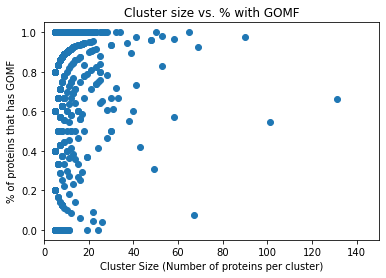

In [53]:
plt.scatter(test.ct_proteins,
           test.has_gomf_percentage)
plt.xlim(0, 150)
plt.xlabel("Cluster Size (Number of proteins per cluster)")
plt.ylabel("% of proteins that has GOMF")
plt.title("Cluster size vs. % with GOMF")
plt.show()

There aren't any obvious correlations between the cluster size and the % of proteins that has GOMF.

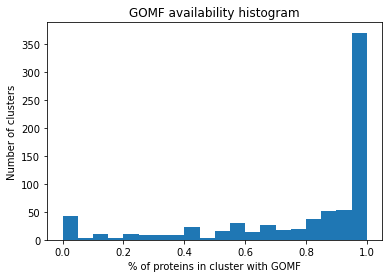

In [55]:
plt.hist(test.has_gomf_percentage,
        20)

plt.xlabel("% of proteins in cluster with GOMF")
plt.ylabel("Number of clusters")
plt.title("GOMF availability histogram")

plt.show()

What does the cluster size distribution look like? 

In this model, 758 clusters including noise. Median is 8 proteins, so we have a really big number of very tiny clusters. Not sure if this is good or bad just yet. This is probably a result of trying to reduce a lot of noise. On one hand, this may be useful for scientists to find out a small number of structurally similar proteins. On the other hand, it may be too granular to reveal something more insightful.

In [68]:
test.ct_proteins.describe()

count      758.00000
mean        27.74934
std        430.94490
min          5.00000
25%          6.00000
50%          8.00000
75%         13.00000
max      11865.00000
Name: ct_proteins, dtype: float64

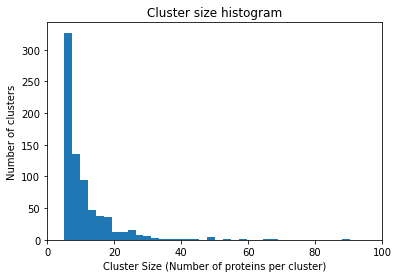

In [67]:
plt.hist(test.ct_proteins, 5000)

plt.xlabel("Cluster Size (Number of proteins per cluster)")
plt.ylabel("Number of clusters")
plt.title("Cluster size histogram")
plt.xlim(0, 100)
plt.show()

Look at that super long tail! I cut off the X axis at the cluster size of 100 proteins, but we know we have five to the right.

In [72]:
test[test.ct_proteins>100].shape[0]

5

Show cluster & parent gomf relations

In [87]:
export = clusters_with_gomf[
    (clusters_with_gomf.has_gomf) &
    (clusters_with_gomf.cluster_label != -1)
].pivot_table(
    index=['cluster_label', 'parent_gomf', 'parent_gomf_name'],
    values='protein_id',
    aggfunc=pd.Series.nunique
).reset_index().fillna(0)

export.to_csv('functional_sim/model_eval/B2_cluster_parent_eval.csv')

In [88]:
export.shape

(1944, 4)

In [97]:
clusters_with_gomf[['protein', 'cluster_label',
       'child_gomf_term_id', 'child_gomf', 'child_gomf_name',
       'child_gomf_desc', 'parent_gomf', 'parent_gomf_name',
       'parent_gomf_desc', 'has_gomf']
                  ].to_csv('functional_sim/model_eval/B2_clusters_with_gomf.csv')

In [98]:
clusters_with_gomf[['protein', 'cluster_label',
       'child_gomf_term_id', 'child_gomf', 'child_gomf_name',
       'child_gomf_desc', 'parent_gomf', 'parent_gomf_name',
       'parent_gomf_desc', 'has_gomf']
                  ].head()

protein  cluster_label child_gomf_term_id  \
0  A0A024R1R8             -1               None   
1  A0A024RBG1             83         GO:0000298   
2  A0A024RBG1             83         GO:0003723   
3  A0A024RBG1             83         GO:0004551   
4  A0A024RBG1             83         GO:0016817   

                                          child_gomf  \
0                                               None   
1                  GOMF_ENDOPOLYPHOSPHATASE_ACTIVITY   
2                                   GOMF_RNA_BINDING   
3             GOMF_NUCLEOTIDE_DIPHOSPHATASE_ACTIVITY   
4  GOMF_HYDROLASE_ACTIVITY_ACTING_ON_ACID_ANHYDRIDES   

                                 child_gomf_name  \
0                                           None   
1                   endopolyphosphatase activity   
2                                    RNA binding   
3              nucleotide diphosphatase activity   
4  hydrolase activity, acting on acid anhydrides   

                                     child_gomf_desc parent_gomf  \
0                                               None        None   
1  Catalysis of the reaction: polyphosphate + n H...  GO:0003824   
2   Binding to an RNA molecule or a portion thereof.  GO:0005488   
3  Catalysis of the reaction: a dinucleotide + H2...  GO:0003824   
4  Catalysis of the hydrolysis of any acid anhydr...  GO:0003824   

     parent_gomf_name                                   parent_gomf_desc  \
0                None                                               None   
1  catalytic activity  Catalysis of a biochemical reaction at physiol...   
2             binding  The selective, non-covalent, often stoichiomet...   
3  catalytic activity  Catalysis of a biochemical reaction at physiol...   
4  catalytic activity  Catalysis of a biochemical reaction at physiol...   

   has_gomf  
0     False  
1      True  
2      True  
3      True  
4      True

# goa_human.gaf

GO annotation files. 

Dataset `goa_human.gaf` downloaded from http://current.geneontology.org/products/pages/downloads.html
> **Filtered Files**
>
> These files are taxon-specific and reflect the work of specific projects, primarily the model organisms database groups, to provide comprehensive, non-redundant annotation files for their organism. All the files in this table have been filtered using the annotation file QC pipeline. A major component to the filtering is the requirement that particular taxon IDs can only be included within the association files provided by specific projects; the current list of authoritative groups and major model organisms can be found below. 

```
Homo sapiens
EBI Gene Ontology Annotation Database (goa) 	protein 	543477 	goa_human.gaf (gzip)
```
Data dictionary: http://geneontology.org/docs/go-annotation-file-gaf-format-2.1/


Funcsim methodology: https://www.nature.com/articles/s41598-018-30455-0
> Functional similarity of a gene pair or a set is determined by the semantic similarities of the GO terms annotating the gene pair or set. Semantic similarity defines a distance between terms in the semantic space of GO and is quantified by the information contents (IC) of the terms. The information content (IC) of a GO term t is defined by negative log-likelihood:
$$IC(t)=-log(p(t))$$
> where term probability P(t) of term t is determined from the annotations of the corpus (corpus-based) or from the structure of the DAG (structure-based). The intuition is that terms in lower levels of DAG, that is, the terms with lower probability carry more specific information than the terms at higher levels in the hierarchy. Corpus-based methods evaluate the term probability as
$$p(t)= \frac{M}{N}$$
where M is the number of genes annotated by term t and N is the total number of genes in the annotating corpus.



In [99]:
a_file = gzip. open("functional_sim/data/goa_human.gaf.gz", "rb")
contents = a_file. read()

In [178]:
print(contents.decode('utf-8')[0:1423])

!gaf-version: 2.2
!
!generated-by: GOC
!
!date-generated: 2021-10-27T15:09
!
!Header from source association file:
!=================================
!
!generated-by: GOC
!
!date-generated: 2021-10-27T04:08
!
!Header from goa_human source association file:
!=================================
!
!The set of protein accessions included in this file is based on UniProt reference proteomes, which provide one protein per gene.
!They include the protein sequences annotated in Swiss-Prot or the longest TrEMBL transcript if there is no Swiss-Prot record.
!If a particular protein accession is not annotated with GO, then it will not appear in this file.
!
!Note that the annotation set in this file is filtered in order to reduce redundancy; the full, unfiltered set can be found in
!ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/UNIPROT/goa_uniprot_all.gz
!
!date-generated: 2021-06-16 11:28
!generated-by: UniProt
!go-version: http://purl.obolibrary.org/obo/go/releases/2021-06-06/extensions/go-plus.owl
!
!

In [135]:
goa = pd.read_csv("functional_sim/data/goa_human.gaf.gz", 
            compression='gzip', 
            header=None,
            skiprows=41, 
            sep='\t')
goa.columns=["DB",
                    "DB Object ID",
                    "DB Object Symbol",
                    "Qualifier",
                    "GO ID",
                    "Reference",
                    "Evidence Code",
                    "With or From",
                    "Aspect",
                    "Name",
                    "Synonym",
                    "Type",
                    "Taxon",
                    "Date",
                    "Assigned By",
                    "Annotation Extension",
                    "Gene Product Form ID"]
goa.head()

/Users/haeranglee/opt/anaconda3/envs/pss/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


DB DB Object ID DB Object Symbol   Qualifier       GO ID  \
0  UniProtKB   A0A024RBG1           NUDT4B     enables  GO:0003723   
1  UniProtKB   A0A024RBG1           NUDT4B     enables  GO:0046872   
2  UniProtKB   A0A024RBG1           NUDT4B     enables  GO:0052840   
3  UniProtKB   A0A024RBG1           NUDT4B     enables  GO:0052842   
4  UniProtKB   A0A024RBG1           NUDT4B  located_in  GO:0005829   

        Reference Evidence Code          With or From Aspect  \
0  GO_REF:0000043           IEA  UniProtKB-KW:KW-0694      F   
1  GO_REF:0000043           IEA  UniProtKB-KW:KW-0479      F   
2  GO_REF:0000003           IEA           EC:3.6.1.52      F   
3  GO_REF:0000003           IEA           EC:3.6.1.52      F   
4  GO_REF:0000052           IDA                   NaN      C   

                                                Name Synonym     Type  \
0  Diphosphoinositol polyphosphate phosphohydrola...  NUDT4B  protein   
1  Diphosphoinositol polyphosphate phosphohydrola...  NUDT4B  protein   
2  Diphosphoinositol polyphosphate phosphohydrola...  NUDT4B  protein   
3  Diphosphoinositol polyphosphate phosphohydrola...  NUDT4B  protein   
4  Diphosphoinositol polyphosphate phosphohydrola...  NUDT4B  protein   

        Taxon      Date Assigned By Annotation Extension  Gene Product Form ID  
0  taxon:9606  20210612     UniProt                  NaN                   NaN  
1  taxon:9606  20210612     UniProt                  NaN                   NaN  
2  taxon:9606  20210612     UniProt                  NaN                   NaN  
3  taxon:9606  20210612     UniProt                  NaN                   NaN  
4  taxon:9606  20161204         HPA                  NaN                   NaN

In [164]:
goa.shape

(609748, 17)

In [137]:
goa["DB"].unique()

array(['UniProtKB'], dtype=object)

In [140]:
goa["Qualifier"].unique()

array(['enables', 'located_in', 'involved_in', 'part_of', 'NOT|enables',
       'NOT|involved_in', 'is_active_in', 'NOT|colocalizes_with',
       'colocalizes_with', 'acts_upstream_of_or_within', 'contributes_to',
       'NOT|located_in', 'NOT|part_of', 'NOT|acts_upstream_of_or_within',
       'acts_upstream_of', 'acts_upstream_of_positive_effect',
       'acts_upstream_of_or_within_positive_effect',
       'acts_upstream_of_or_within_negative_effect', 'NOT|contributes_to',
       'acts_upstream_of_negative_effect',
       'NOT|acts_upstream_of_or_within_negative_effect',
       'NOT|is_active_in'], dtype=object)

In [184]:
len(goa["DB Object ID"].unique())

19788

In [185]:
# DB Object Symbol
len(goa["DB Object Symbol"].unique())

19718

In [139]:
len(goa["GO ID"].unique())

18527

In [141]:
goa["Evidence Code"].unique()

array(['IEA', 'IDA', 'TAS', 'IPI', 'IEP', 'ISS', 'NAS', 'IMP', 'ISA',
       'HDA', 'EXP', 'ND', 'HEP', 'IC', 'RCA', 'HMP', 'IGI', 'IKR', 'IGC',
       'ISO', 'ISM', 'IBA'], dtype=object)

Taxonomy should be human. Some proteins may be found in multiple organisms other than human, but in the end, every data point in this dataset is in some way related to human.

In [183]:
goa["Taxon"].unique()[0:10]

array(['taxon:9606', 'taxon:9606|taxon:1280', 'taxon:9606|taxon:33892',
       'taxon:9606|taxon:11103', 'taxon:9606|taxon:11052',
       'taxon:9606|taxon:562', 'taxon:9606|taxon:197911',
       'taxon:9606|taxon:90370', 'taxon:9606|taxon:31649',
       'taxon:9606|taxon:1313'], dtype=object)

In [182]:
[taxon for taxon in goa["Taxon"].unique() if '9606' not in taxon]

[]

Can I find all GO in the human GOA dataset within GO BASIC?

In [165]:
goa_goid_set = set(goa["GO ID"])
gobasic_set = set(shortest_from_root.keys())

In [166]:
goa_goid_set.difference(gobasic_set)

set()

GOA is a subset of gobasic, which is the full graph. 

In [168]:
len(gobasic_set.difference(goa_goid_set))

25323

I want to work only with GOMF. 

In [193]:
# GOMF only 

goa_goid_mf = [goid for goid in set(goa["GO ID"]) if goid in shortest_from_root['GO:0003674'] ]
len(goa_goid_mf)

4431

In [194]:
goa_goid_mf[0:10]

['GO:0005412',
 'GO:0035254',
 'GO:0005035',
 'GO:0031690',
 'GO:0046980',
 'GO:1990247',
 'GO:0050567',
 'GO:0052630',
 'GO:0052814',
 'GO:0003943']

> M is the number of genes annotated by term t

In [210]:
M = goa[goa['GO ID'].isin(goa_goid_mf)].pivot_table(index='GO ID',
                values='DB Object Symbol',
                aggfunc=pd.Series.nunique
               ).to_dict()['DB Object Symbol']

In [211]:
M

{'GO:0000009': 2,
 'GO:0000010': 2,
 'GO:0000014': 9,
 'GO:0000016': 1,
 'GO:0000026': 4,
 'GO:0000030': 19,
 'GO:0000033': 3,
 'GO:0000035': 2,
 'GO:0000036': 1,
 'GO:0000048': 5,
 'GO:0000049': 73,
 'GO:0000062': 17,
 'GO:0000064': 5,
 'GO:0000095': 1,
 'GO:0000104': 2,
 'GO:0000121': 1,
 'GO:0000140': 1,
 'GO:0000146': 31,
 'GO:0000149': 64,
 'GO:0000150': 2,
 'GO:0000166': 64,
 'GO:0000170': 1,
 'GO:0000171': 1,
 'GO:0000175': 32,
 'GO:0000179': 4,
 'GO:0000182': 5,
 'GO:0000210': 3,
 'GO:0000213': 2,
 'GO:0000215': 2,
 'GO:0000217': 2,
 'GO:0000224': 1,
 'GO:0000225': 1,
 'GO:0000246': 1,
 'GO:0000247': 2,
 'GO:0000248': 2,
 'GO:0000250': 1,
 'GO:0000252': 1,
 'GO:0000253': 5,
 'GO:0000254': 3,
 'GO:0000268': 4,
 'GO:0000285': 3,
 'GO:0000287': 220,
 'GO:0000293': 1,
 'GO:0000295': 2,
 'GO:0000298': 5,
 'GO:0000309': 3,
 'GO:0000334': 1,
 'GO:0000339': 12,
 'GO:0000340': 13,
 'GO:0000386': 1,
 'GO:0000400': 17,
 'GO:0000403': 5,
 'GO:0000404': 1,
 'GO:0000405': 8,
 'GO:0000406': 2

In [213]:
len(M)

4431

> N is the total number of genes in the annotating corpus.

In [217]:
N = len(goa[goa['GO ID'].isin(goa_goid_mf)]['DB Object Symbol'].unique())
N

18194

> The information content (IC) of a GO term t is defined by negative log-likelihood:
$$IC(t)=-log(p(t))$$
> where term probability P(t) of term t is determined from the annotations of the corpus (corpus-based) or from the structure of the DAG (structure-based). [...] Corpus-based methods evaluate the term probability as
$$p(t)= \frac{M}{N}$$

In [221]:
IC_t = {
    t: -np.log(m/N) for t, m in M.items()
}

In [222]:
IC_t

{'GO:0000009': 9.115699967822062,
 'GO:0000010': 9.115699967822062,
 'GO:0000014': 7.611622571045788,
 'GO:0000016': 9.808847148382007,
 'GO:0000026': 8.422552787262116,
 'GO:0000030': 6.864408169215567,
 'GO:0000033': 8.710234859713898,
 'GO:0000035': 9.115699967822062,
 'GO:0000036': 9.808847148382007,
 'GO:0000048': 8.199409235947908,
 'GO:0000049': 5.518387707233615,
 'GO:0000062': 6.975633804325791,
 'GO:0000064': 8.199409235947908,
 'GO:0000095': 9.808847148382007,
 'GO:0000104': 9.115699967822062,
 'GO:0000121': 9.808847148382007,
 'GO:0000140': 9.808847148382007,
 'GO:0000146': 6.374859943896861,
 'GO:0000149': 5.649964065022336,
 'GO:0000150': 9.115699967822062,
 'GO:0000166': 5.649964065022336,
 'GO:0000170': 9.808847148382007,
 'GO:0000171': 9.808847148382007,
 'GO:0000175': 6.343111245582281,
 'GO:0000179': 8.422552787262116,
 'GO:0000182': 8.199409235947908,
 'GO:0000210': 8.710234859713898,
 'GO:0000213': 9.115699967822062,
 'GO:0000215': 9.115699967822062,
 'GO:0000217':

> **Functional similarity measures between two genes**
> 
> Functional similarity (FS) between two genes is computed using the ICs of individual terms (term-based) or the semantic similarities between the pairs of terms (term pair-based) or among the set of terms (term set-based). Let 𝑇𝑔1
and 𝑇𝑔2 be the set of GO terms annotating genes g1 and g2, respectively. Term-based measures such as GIC1 (Jaccard index), DIC39 (dice index), and UIC39 (universal index) are defined using ICs of individual terms:
>
> GIC
$$FS({g}_{1},\,{g}_{2})=\frac{{\sum }_{t\in {T}_{{g}_{1}}\cap {T}_{{g}_{2}}}IC(t)}{{\sum }_{t\in {T}_{{g}_{1}}\cup {T}_{{g}_{2}}}IC(t)}$$


For each protein (instead of gene) find the set of relevant terms.

In [234]:
goa_by_protein = goa[goa['GO ID'].isin(goa_goid_mf)].pivot_table(
    index=["DB Object Symbol"],
    values=["GO ID"],
    aggfunc=lambda x:set(x)
).to_dict()['GO ID']

goa_by_protein

{'A0A087WT57': {'GO:0019901'},
 'A0A087WUV0': {'GO:0046872'},
 'A0A087WWC5': {'GO:0003682', 'GO:0042393'},
 'A0A087WZV9': {'GO:0051500'},
 'A0A087X0B3': {'GO:0008392', 'GO:0008395', 'GO:0016712', 'GO:0020037'},
 'A0A087X1B8': {'GO:0050080'},
 'A0A096LPK6': {'GO:0019899', 'GO:0030234'},
 'A0A0B4J293': {'GO:0036435', 'GO:0061630', 'GO:0070530', 'GO:1990450'},
 'A0A0C4DFX4': {'GO:0016887', 'GO:0042393'},
 'A0A0D9SEW6': {'GO:0005507'},
 'A0A0G2JMS6': {'GO:0004867'},
 'A0A0G2JNH3': {'GO:0004930', 'GO:0004984'},
 'A0A0G2JS52': {'GO:0000978', 'GO:0000981'},
 'A0A0J9YVX5': {'GO:0044325'},
 'A0A0J9YYC4': {'GO:0000900', 'GO:0003730', 'GO:0008135', 'GO:0043022'},
 'A0A0J9YYD9': {'GO:0019901'},
 'A0A0U1RQV5': {'GO:0043023'},
 'A0A140TA62': {'GO:0005198'},
 'A0A1B0GU22': {'GO:0016798'},
 'A0A1B0GUL7': {'GO:0004672', 'GO:0005524'},
 'A0A1B0GVI7': {'GO:0000976', 'GO:0004879'},
 'A0A1B0GVJ0': {'GO:0016798'},
 'A0A1B0GW94': {'GO:0016798'},
 'A0A1B0GWJ7': {'GO:0016798'},
 'A0A1W2PPV4': {'GO:0005249', 'G

In [235]:
len(goa_by_protein)

18193

In [254]:
protein_A = 'ABCC3'
protein_B = 'ABCC4'

In [255]:
goa_by_protein[protein_A]

{'GO:0005524',
 'GO:0008559',
 'GO:0015164',
 'GO:0015431',
 'GO:0015432',
 'GO:0042626',
 'GO:0042910',
 'GO:0043225',
 'GO:0071714'}

In [273]:
gobasic['GO:0071714']

AdjacencyView({'GO:0022857': {'is_a': {}}})

In [280]:
gobasic['GO:0022857']

AdjacencyView({'GO:0005215': {'is_a': {}}})

In [283]:
sorted(goa[goa["DB Object Symbol"]=='ABCC3']["GO ID"].unique())

['GO:0005524',
 'GO:0005886',
 'GO:0006855',
 'GO:0008559',
 'GO:0015164',
 'GO:0015431',
 'GO:0015432',
 'GO:0015698',
 'GO:0015721',
 'GO:0015779',
 'GO:0016020',
 'GO:0016021',
 'GO:0016323',
 'GO:0042626',
 'GO:0042908',
 'GO:0042910',
 'GO:0043225',
 'GO:0055085',
 'GO:0071714',
 'GO:0071716',
 'GO:0150104']

In [256]:
goa_by_protein[protein_B]

{'GO:0001409',
 'GO:0005515',
 'GO:0005524',
 'GO:0008559',
 'GO:0015132',
 'GO:0015143',
 'GO:0015216',
 'GO:0015431',
 'GO:0015432',
 'GO:0015562',
 'GO:0015662',
 'GO:0016404',
 'GO:0034634',
 'GO:0042626',
 'GO:0042910',
 'GO:0043225'}

In [257]:
# Intersection of the terms
goa_by_protein[protein_A].intersection(goa_by_protein[protein_B])

{'GO:0005524',
 'GO:0008559',
 'GO:0015431',
 'GO:0015432',
 'GO:0042626',
 'GO:0042910',
 'GO:0043225'}

In [247]:
def funsim(protein_A, protein_B, IC_t):
    """Find GIC or the Jaccard index of terms between two proteins.
    https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-S5-S4
    """
    
    go_intersection = goa_by_protein[protein_A].intersection(goa_by_protein[protein_B])
    go_union        = goa_by_protein[protein_A].union(       goa_by_protein[protein_B])
    
    numerator = 0
    denominator = 0
    
    for goid in go_intersection:
        numerator += IC_t[goid]
        
    denominator = numerator
    for goid in go_union - go_intersection:
        denominator += IC_t[goid]
        
    return numerator/denominator

In [248]:
funsim(protein_A, protein_B, IC_t)

0.3449657637213769

In [258]:
go_intersection = goa_by_protein[protein_A].intersection(goa_by_protein[protein_B])
go_union        = goa_by_protein[protein_A].union(       goa_by_protein[protein_B])

numerator = 0
denominator = 0

for goid in go_intersection:
    numerator += IC_t[goid]
    print(goid, "Freq", M[goid], " IC", IC_t[goid], " total numerator:", numerator)
    

print()
denominator = numerator
for goid in go_union - go_intersection:
    denominator += IC_t[goid]
    print(goid, "Freq", M[goid], IC_t[goid], denominator)


GO:0005524 Freq 1479  IC 2.5097256856712074  total numerator: 2.5097256856712074
GO:0015432 Freq 4  IC 8.422552787262116  total numerator: 10.932278472933323
GO:0042910 Freq 19  IC 6.864408169215567  total numerator: 17.79668664214889
GO:0008559 Freq 15  IC 7.100796947279798  total numerator: 24.89748358942869
GO:0015431 Freq 8  IC 7.729405606702171  total numerator: 32.62688919613086
GO:0043225 Freq 10  IC 7.506262055387961  total numerator: 40.133151251518825
GO:0042626 Freq 44  IC 6.024657514463747  total numerator: 46.15780876598257

GO:0015216 Freq 3 8.710234859713898 54.86804362569647
GO:0071714 Freq 1 9.808847148382007 64.67689077407849
GO:0015662 Freq 6 8.017087679153953 72.69397845323243
GO:0015562 Freq 14 7.169789818766748 79.86376827199918
GO:0015132 Freq 2 9.115699967822062 88.97946823982124
GO:0034634 Freq 5 8.199409235947908 97.17887747576916
GO:0001409 Freq 2 9.115699967822062 106.29457744359122
GO:0015143 Freq 5 8.199409235947908 114.49398667953913
GO:0015164 Freq 1 9.8

In [249]:
M

{'GO:0000009': 2,
 'GO:0000010': 2,
 'GO:0000014': 9,
 'GO:0000016': 1,
 'GO:0000026': 4,
 'GO:0000030': 19,
 'GO:0000033': 3,
 'GO:0000035': 2,
 'GO:0000036': 1,
 'GO:0000048': 5,
 'GO:0000049': 73,
 'GO:0000062': 17,
 'GO:0000064': 5,
 'GO:0000095': 1,
 'GO:0000104': 2,
 'GO:0000121': 1,
 'GO:0000140': 1,
 'GO:0000146': 31,
 'GO:0000149': 64,
 'GO:0000150': 2,
 'GO:0000166': 64,
 'GO:0000170': 1,
 'GO:0000171': 1,
 'GO:0000175': 32,
 'GO:0000179': 4,
 'GO:0000182': 5,
 'GO:0000210': 3,
 'GO:0000213': 2,
 'GO:0000215': 2,
 'GO:0000217': 2,
 'GO:0000224': 1,
 'GO:0000225': 1,
 'GO:0000246': 1,
 'GO:0000247': 2,
 'GO:0000248': 2,
 'GO:0000250': 1,
 'GO:0000252': 1,
 'GO:0000253': 5,
 'GO:0000254': 3,
 'GO:0000268': 4,
 'GO:0000285': 3,
 'GO:0000287': 220,
 'GO:0000293': 1,
 'GO:0000295': 2,
 'GO:0000298': 5,
 'GO:0000309': 3,
 'GO:0000334': 1,
 'GO:0000339': 12,
 'GO:0000340': 13,
 'GO:0000386': 1,
 'GO:0000400': 17,
 'GO:0000403': 5,
 'GO:0000404': 1,
 'GO:0000405': 8,
 'GO:0000406': 2

In [269]:
{go:ic for go, ic in IC_t.items() if go in topmf}

{'GO:0003774': 6.513010282377678,
 'GO:0003824': 6.343111245582281,
 'GO:0005198': 4.702901674481426,
 'GO:0005215': 6.197929235737782,
 'GO:0016209': 6.918475390485843,
 'GO:0031386': 7.169789818766748,
 'GO:0038024': 7.036258426142226,
 'GO:0044183': 6.119967694268071,
 'GO:0045182': 6.864408169215567,
 'GO:0060090': 5.532181029365952,
 'GO:0140110': 7.729405606702171,
 'GO:0140223': 8.710234859713898}

In [270]:
{go:ct for go, ct in M.items() if go in topmf}

{'GO:0003774': 27,
 'GO:0003824': 32,
 'GO:0005198': 165,
 'GO:0005215': 37,
 'GO:0016209': 18,
 'GO:0031386': 14,
 'GO:0038024': 16,
 'GO:0044183': 40,
 'GO:0045182': 19,
 'GO:0060090': 72,
 'GO:0140110': 8,
 'GO:0140223': 3}

In [284]:
topmf

['GO:0003774',
 'GO:0003824',
 'GO:0005198',
 'GO:0005215',
 'GO:0005488',
 'GO:0016209',
 'GO:0031386',
 'GO:0038024',
 'GO:0044183',
 'GO:0045182',
 'GO:0045735',
 'GO:0060089',
 'GO:0060090',
 'GO:0090729',
 'GO:0098772',
 'GO:0140104',
 'GO:0140110',
 'GO:0140223',
 'GO:0140299',
 'GO:0140313',
 'GO:0140489',
 'GO:0140522',
 'GO:0140657',
 'GO:0140691']

* In GO molecular functions (GOMF) 11,000 GOMF terms 
* In the data I downloaded (human proteins mapped to GOMF), I got 4,000
* There are 18 top parent GOMF (right under molecular function)
* Only 10 or so are found in my protein-to-GO data, and the count of proteins that even have one of these is <300 (out of 20,000 human proteins)